**CURSO**: Análisis Geoespacial, Departamento de Geociencias y Medio Ambiente, Universidad Nacional de Colombia - sede Medellín <br/>
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from de Python Spatial Analysis Library [Pysal](https://pysal.org/), and the courses and book open and freely published by [Dani Arribas-Bel](http://darribas.org/) -  University of Liverpool & - Sergio Rey - [Center for Geospatial Sciences, University of California, Riverside](http://spatial.ucr.edu/peopleRey.html).

# Regresión Espacial


La regresión (y la predicción en general) nos proporciona un caso perfecto para examinar cómo la estructura espacial puede ayudarnos a comprender y analizar nuestros datos. Por lo general, la estructura espacial ayuda a los modelos de dos maneras. La primera (y más clara) manera en que el espacio puede tener un impacto en nuestros datos es cuando el proceso que genera los datos es explícitamente espacial. Aquí, piensa en algo como los precios de las casas unifamiliares. A menudo sucede que las personas pagan un precio premium por su casa para vivir en un mejor distrito escolar para la misma calidad de casa. Alternativamente, las casas más cercanas a contaminantes acústicos o químicos como plantas de tratamiento de aguas residuales, instalaciones de reciclaje o carreteras anchas, pueden ser más baratas de lo que anticiparíamos. Finalmente, en casos como la incidencia de asma, los lugares a los que las personas tienden a viajar a lo largo del día, como sus lugares de trabajo o recreación, pueden tener más impacto en su salud que sus direcciones residenciales. En este caso, puede ser necesario utilizar datos de *otros sitios* para predecir la incidencia de asma en un sitio dado. Independientemente del caso específico en juego, aquí, **la geografía es una característica**: nos ayuda directamente a hacer predicciones sobre resultados *porque esos resultados provienen de procesos geográficos*.

Una comprensión alternativa (y más escéptica) reconoce a regañadientes el valor instrumental de la geografía. A menudo, en el análisis de métodos predictivos y clasificadores, estamos interesados en analizar lo que fallamos. Esto es común en econometría; un analista puede estar preocupado de que el modelo *sistemáticamente* prediga mal algunos tipos de observaciones. Si sabemos que nuestro modelo rutinariamente se desempeña mal en un conjunto conocido de observaciones o tipo de entrada, podríamos hacer un mejor modelo si podemos tener en cuenta esto. Entre otros tipos de diagnósticos de errores, la geografía nos proporciona un incrustación excepcionalmente útil para evaluar la estructura en nuestros errores. Mapear el error de clasificación/predicción puede ayudar a mostrar si hay *grupos de errores* en nuestros datos. Si *sabemos* que los errores tienden a ser mayores en algunas áreas que en otras áreas (o si el error es "contagioso" entre observaciones), entonces podríamos aprovechar esta estructura para hacer mejores predicciones.

La estructura espacial en nuestros errores puede surgir de cuando la geografía *debería ser* de alguna manera un atributo, pero no estamos seguros exactamente de cómo incluirla en nuestro modelo. También pueden surgir porque hay alguna otra característica cuya omisión causa los patrones espaciales en el error que vemos; si esta característica adicional se incluyera, la estructura desaparecería. O podría surgir de las complejas interacciones e interdependencias entre las características que hemos elegido usar como predictores, lo que resulta en una estructura intrínseca en la mala predicción. La mayoría de los predictores que usamos en modelos de procesos sociales contienen información espacial *incorporada*: patrones intrínsecos a la característica que obtenemos de forma gratuita en el modelo. Si lo pretendemos o no, usar un predictor con patrón espacial en un modelo puede resultar en errores con patrón espacial; usar más de uno puede amplificar este efecto. Por lo tanto, *independientemente de si el verdadero proceso es explícitamente geográfico*, información adicional sobre las relaciones espaciales entre nuestras observaciones o más información sobre sitios cercanos puede hacer que nuestras predicciones sean mejores.

### Los Datos: AirBnB en San Diego

Para aprender un poco más sobre cómo funciona la regresión, examinaremos información sobre AirBnB en San Diego, CA. Este conjunto de datos contiene características intrínsecas de la casa, tanto continuas (número de camas como en `beds`) como categóricas (tipo de alquiler o, en el argot de AirBnb, grupo de propiedades como en las series de variables binarias de `pg_X`), pero también variables que se refieren explícitamente a la ubicación y configuración espacial del conjunto de datos (por ejemplo, distancia al Parque Balboa, `d2balboa` o identificación de vecindario, `neighbourhood_cleansed`).


In [ ]:
%matplotlib inline

from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
from scipy import stats
import statsmodels.formula.api as sm
import numpy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn

In [6]:
db = gpd.read_file('https://geographicdata.science/book/_downloads/dcd429d1761a2d0efdbc4532e141ba14/regression_db.geojson')

In [3]:
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

<AxesSubplot:>

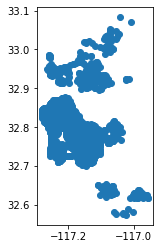

In [ ]:
db.plot()

In [ ]:
db.head(2)

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)


Estas son las variables explicativas que utilizaremos a lo largo del libro.


In [ ]:
variable_names = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'rt_Private_room', 'rt_Shared_room', 'pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse']

## Regresión no espacial

Antes de discutir cómo incluir explícitamente el espacio en el marco de regresión lineal, vamos a mostrar cómo se puede llevar a cabo la regresión básica en Python y cómo se pueden comenzar a interpretar los resultados. La idea principal de la regresión lineal es explicar la variación en una variable (*dependiente*) dada como una función lineal de una colección de otras variables (*explicativas*). Por ejemplo, en nuestro caso, podemos querer expresar/explicar el precio de una casa como una función de si es nueva y el grado de privación del área donde se encuentra. A nivel individual, podemos expresar esto como:

$$
P_i = \alpha + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

donde $P_i$ es el precio de AirBnb de la casa $i$, y $X$ es un conjunto de covariables que usamos para explicar tal precio. $\beta$ es un vector de parámetros que nos dan información sobre de qué manera y en qué medida cada variable está relacionada con el precio, y $\alpha$, el término constante, es el precio promedio de la casa cuando todas las otras variables son cero. El término $\epsilon_i$ se refiere comúnmente como "error" y captura elementos que influyen en el precio de una casa pero que no están incluidos en $X$. También podemos expresar esta relación en forma de matriz, excluyendo subíndices para $i$, lo que produce:

$$
P = \alpha + \mathbf{X}\beta + \epsilon
$$

Una regresión se puede ver como una extensión multivariable de correlaciones bivariadas. De hecho, una forma de interpretar los coeficientes $\beta_k$ en la ecuación anterior es como el grado de correlación entre la variable explicativa $k$ y la variable dependiente, *manteniendo constantes todas las demás variables explicativas*. Cuando se calculan correlaciones bivariadas, el coeficiente de una variable está captando la correlación entre las variables, pero también está subsumiendo en ella la variación asociada con otras variables correlacionadas, también llamadas factores de confusión. La regresión nos permite aislar el efecto distinto que tiene una sola variable sobre la dependiente, una vez que controlamos por esas otras variables.

En términos prácticos, las regresiones lineales en Python son bastante sencillas y fáciles de trabajar. También hay varios paquetes que las ejecutarán (por ejemplo, `statsmodels`, `scikit-learn`, `PySAL`). En el contexto de este capítulo, tiene sentido comenzar con `PySAL`, ya que es la única biblioteca que nos permitirá pasar a modelos econométricos explícitamente espaciales. Para ajustar el modelo especificado en la ecuación anterior con $X$ como la lista definida, solo necesitamos la siguiente línea de código:


In [ ]:
m1 = spreg.OLS(db[['log_price']].values, db[variable_names].values, name_y='log_price', name_x=variable_names)

Utilizamos el comando `OLS`, parte del subpaquete `spreg`, y especificamos la variable dependiente (el logaritmo del precio, para poder interpretar los resultados en términos de cambio porcentual) y las variables explicativas. Ten en cuenta que ambos objetos deben ser matrices, por lo que los extraemos del objeto `pandas.DataFrame` usando `.values`.

Para inspeccionar los resultados del modelo, podemos llamar a `summary:


In [ ]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:    1320.148                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

-----------------------------------------------------------------------------

Este mismo modelo se puede correr utilizando la función *ols* de *statsmodels* de la siguiente manera:

In [ ]:
m0=sm.ols("log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse", data=db).fit()

In [ ]:
print(m0.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     1229.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        08:07:29   Log-Likelihood:                -3988.9
No. Observations:                6110   AIC:                             8000.
Df Residuals:                    6099   BIC:                             8074.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.3884      0.016    2

Los `Coeficientes` nos dan las estimaciones para $\beta_k$ en nuestro modelo. En otras palabras, estos números expresan la relación entre cada variable explicativa y la variable dependiente, una vez que se ha tenido en cuenta el efecto de los factores de confusión. Sin embargo, ten en cuenta que la regresión no es magia; solo estamos descontando el efecto de los factores de confusión que incluimos en el modelo, no de *todos* los factores potencialmente confusos.

Los resultados son en su mayoría como se esperaba: las casas tienden a ser significativamente más caras si acomodan a más personas (`accommodates`), si tienen más baños y dormitorios y si son un condominio o parte de la categoría "otro" tipo de vivienda. Por otro lado, dada una cantidad de habitaciones, las casas con más camas (es decir, listados más "abarrotados") tienden a ser más baratas, como es el caso de las propiedades donde no se alquila toda la casa sino solo una habitación (`rt_Private_room`) o incluso se comparte (`rt_Shared_room`). Por supuesto, podrías dudar conceptualmente de la suposición de que es posible *cambiar arbitrariamente* el número de camas dentro de un Airbnb sin eventualmente cambiar el número de personas que acomoda, pero los métodos para abordar estas preocupaciones usando *efectos de interacción* no se discutirán aquí.

En general, nuestro modelo se desempeña bien, siendo capaz de predecir ligeramente más del 66% ($R^2=0.66$) de la variación en el precio medio por noche usando las covariables que hemos discutido anteriormente. Pero, nuestro modelo podría mostrar cierto agrupamiento en los errores. Para investigar esto, podemos hacer algunas cosas. Un concepto simple podría ser observar la correlación entre el error en la predicción de un airbnb y el error en la predicción de su vecino más cercano. Para examinar esto, primero podríamos querer dividir nuestros datos por regiones y ver si tenemos alguna estructura espacial en nuestros residuos. Una teoría razonable podría ser que nuestro modelo no incluye ninguna información sobre *playas*, un aspecto crítico de por qué las personas viven y vacacionan en San Diego. Por lo tanto, podríamos querer ver si nuestros errores son mayores o menores dependiendo de si un airbnb está en un vecindario "de playa", un vecindario cerca del océano:


A continuación se obtienen los residuos para el modelo cuando la variable *is_coastal* es igual a *True*, lo cual significa que la casa está localizada sobre la costa, y cuando es *False*.

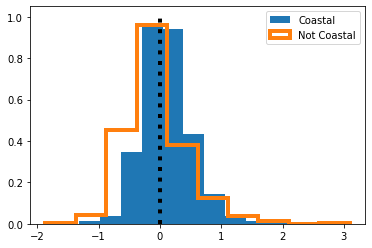

In [ ]:
is_coastal = db.coastal.astype(bool)
coastal = m1.u[is_coastal]
not_coastal = m1.u[~is_coastal]
plt.hist(coastal, density=True, label='Coastal')
plt.hist(not_coastal, histtype='step', density=True, linewidth=4, label='Not Coastal')
plt.vlines(0,0,1, linestyle=":", color='k', linewidth=4)
plt.legend()
plt.show()

Aunque parece que los vecindarios en la costa tienen errores promedio solo ligeramente más altos (y tienen menor varianza en sus errores de predicción), las dos distribuciones son significativamente distintas entre sí cuando se comparan usando una prueba $t$ clásica:


In [ ]:
stats.ttest_ind(coastal, not_coastal)
# permutations=9999 not yet available in scipy

Ttest_indResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]))

Sin embargo, existen pruebas más sofisticadas (y más difíciles de engañar) que pueden ser aplicables para estos datos.


Además, podría ser el caso de que algunos vecindarios sean más deseables que otros debido a preferencias latentes o estrategias de marketing no modeladas. Por ejemplo, a pesar de su ubicación cerca del mar, vivir cerca de Camp Pendleton, una base de Marines en el norte de la ciudad, podría incurrir en algunas penalizaciones significativas en la deseabilidad del área debido al ruido y la contaminación. Para determinar si este es el caso, podríamos estar interesados en la distribución completa de los residuos del modelo dentro de cada vecindario.

Para hacer esto más claro, primero ordenaremos los datos por la mediana residual en ese vecindario, y luego haremos un diagrama de caja, que muestra la distribución de los residuos en cada vecindario:


In [ ]:
db.head(2)

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry,residual
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,...,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399),0.650578
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,...,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421),-0.040253


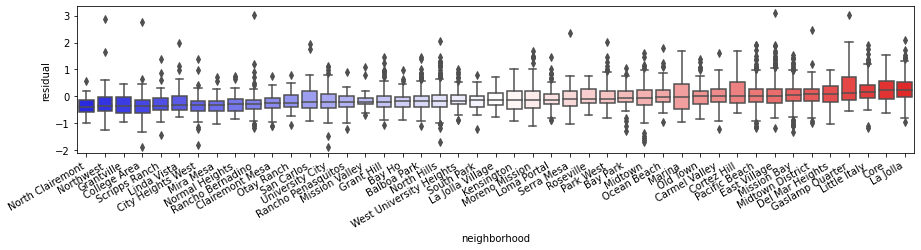

In [ ]:
db['residual'] = m1.u
medians = db.groupby("neighborhood").residual.median().to_frame('hood_residual')

f = plt.figure(figsize=(15,3))
ax = plt.gca()
seaborn.boxplot('neighborhood', 'residual', ax = ax,
                data=db.merge(medians, how='left',left_on='neighborhood',right_index=True).sort_values('hood_residual'), palette='bwr')
f.autofmt_xdate()
plt.show()

Ningún vecindario está completamente aislado de los demás, pero algunos parecen ser más destacados que otros, como las conocidas áreas turísticas del centro de la ciudad, como Gaslamp Quarter, Little Italy o The Core. Por lo tanto, puede haber un efecto distintivo de la moda del vecindario que importa en este modelo.

Observando que muchos de los vecindarios más sobre y subestimados están cerca unos de otros en la ciudad, también puede ser el caso de que haya algún tipo de *contagio* o derrame espacial en el precio del alquiler nocturno. Esto a menudo es evidente cuando las personas buscan fijar el precio de sus listados de Airbnb para competir con listados similares cercanos. Dado que nuestro modelo no es consciente de este comportamiento, es posible que sus errores tiendan a agruparse. Una forma excepcionalmente simple de investigar esta estructura es examinando la relación entre los residuos de una observación y los residuos circundantes.

Para hacer esto, utilizaremos *pesos espaciales* para representar las relaciones geográficas entre las observaciones. Para este ejemplo, comenzaremos con una matriz $KNN$ donde $k=5$, lo que significa que nos enfocaremos solo en los enlaces de cada Airbnb con sus otros listados más cercanos.


In [ ]:
knn = weights.KNN.from_dataframe(db, k=5)

Esto significa que, cuando calculamos el *lag espacial* de ese peso knn y el residuo, obtenemos el residuo del listado de Airbnb más cercano a cada observación.


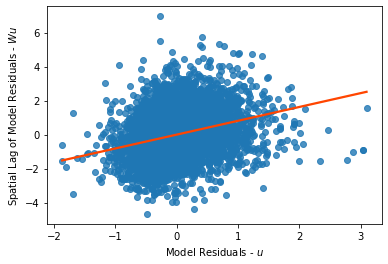

In [ ]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u) # se obtiene la columna spatial_lag de la matris denominada Weights y se le calcula el espacial lag con la matriz de KNN
ax = seaborn.regplot(m1.u.flatten(), lag_residual.flatten(),line_kws=dict(color='orangered'),ci=None)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

En este gráfico, ¡vemos que nuestros errores de predicción tienden a agruparse!
Arriba, mostramos la relación entre nuestro error de predicción en cada sitio y el error de predicción en el sitio más cercano a él.
Aquí, estamos utilizando este sitio más cercano para representar el *entorno* de ese Airbnb.
Esto significa que, cuando el modelo tiende a sobreestimar el precio logarítmico nocturno de un determinado Airbnb, es más probable que los sitios alrededor de ese Airbnb también sean *sobreestimados*.


Una propiedad interesante de esta relación es que tiende a estabilizarse a medida que aumenta el número de vecinos más cercanos utilizados para construir el entorno de cada Airbnb.

Dado este comportamiento, veamos el número estable de vecinos $k=20$.
Examinando la relación entre este promedio estable del *entorno* y el Airbnb focal, incluso podemos encontrar clusters en el error de nuestro modelo.
Recordando las estadísticas de *Moran local*, podemos identificar ciertas áreas donde nuestras predicciones del precio nocturno (logarítmico) de Airbnb tienden a ser significativamente incorrectas:


/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


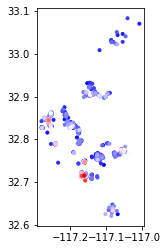

In [ ]:
knn.reweight(k=20, inplace=True)
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
error_clusters = (outliers.q % 2 == 1) # only the cluster cores
error_clusters &= (outliers.p_sim <= .001) # filtering out non-significant clusters
db.assign(error_clusters = error_clusters, local_I = outliers.Is).query("error_clusters").sort_values('local_I').plot('local_I', cmap='bwr', marker='.');

Por lo tanto, estas áreas tienden a ser lugares donde nuestro modelo subestima significativamente el precio nocturno de Airbnb tanto para esa observación específica como para las observaciones en sus alrededores inmediatos.
Esto es crítico porque, si podemos identificar cómo están estructuradas estas áreas y tienen una *geografía consistente* que podemos modelar, entonces podríamos mejorar nuestras predicciones, o al menos no predecir sistemáticamente mal los precios en algunas áreas mientras que predecimos correctamente los precios en otras áreas.

Dado que las subestimaciones y sobreestimaciones significativas parecen agruparse de manera altamente estructurada, podríamos usar un modelo mejor para corregir la geografía de los errores de nuestro modelo.
 


### Ingeniería de características espaciales

Utilizar información geográfica para "construir" nuevos datos es un enfoque común para incorporar información espacial en el análisis geográfico. A menudo, esto refleja el hecho de que los procesos no son iguales en todas partes en el mapa de análisis, o que la información geográfica puede ser útil para predecir nuestro resultado de interés. En esta sección, presentaremos brevemente cómo usar *características espaciales*, o variables $X$ que se construyen a partir de relaciones geográficas, en un modelo lineal estándar.

#### Variables de proximidad

Para empezar, una variable relevante impulsada por la proximidad que podría influir en nuestro modelo se basa en la proximidad de las listas al Parque Balboa. Un destino turístico común, el Parque Balboa es un centro recreativo central para la ciudad de San Diego, que contiene muchos museos y el zoológico de San Diego. Por lo tanto, podría ser el caso de que las personas que buscan Airbnbs en San Diego estén dispuestas a pagar más para vivir más cerca del parque. Si esto fuera cierto *y* lo omitiéramos de nuestro modelo, de hecho podríamos ver un patrón espacial significativo causado por este efecto de decaimiento de la distancia.

Por lo tanto, a esto a veces se le llama una *covariable omitida con patrón espacial*: información geográfica que nuestro modelo necesita para hacer buenas predicciones y que hemos dejado fuera de nuestro modelo. Por lo tanto, construyamos un nuevo modelo que contenga esta covariable de distancia al Parque Balboa. Sin embargo, primero es útil visualizar la estructura de esta covariable de distancia en sí misma:


<AxesSubplot:>

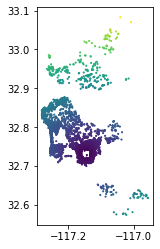

In [ ]:
db.plot('d2balboa', marker='.', s=5)

In [ ]:
base_names = variable_names
balboa_names = variable_names + ['d2balboa']

In [ ]:
m2 = spreg.OLS(db[['log_price']].values, db[balboa_names].values,name_y = 'log_price', name_x = balboa_names)

Desafortunadamente, al inspeccionar los diagnósticos de regresión y la salida, se observa que esta covariable no es tan útil como podríamos anticipar. No es estadísticamente significativa a niveles de significancia convencionales, y el ajuste del modelo no cambia sustancialmente.


In [ ]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          12
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6098
R-squared           :      0.6685
Adjusted R-squared  :      0.6679
Sum squared residual:    1319.522                F-statistic           :   1117.9338
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3987.446
Sigma-square ML     :       0.216                Akaike info criterion :    7998.892
S.E of regression ML:      0.4647                Schwarz criterion     :    8079.504

-----------------------------------------------------------------------------

And, there still appears to be spatial structure in our model's errors:

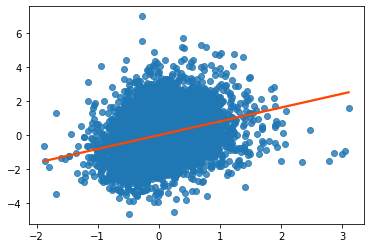

In [ ]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m2.u)
seaborn.regplot(m2.u.flatten(), lag_residual.flatten(),line_kws=dict(color='orangered'),ci=None);

Finalmente, la variable de distancia al Parque Balboa no se ajusta a nuestra teoría sobre cómo debería afectar el precio de un Airbnb la distancia a un lugar de interés; el estimado del coeficiente es *positivo*, lo que significa que las personas están pagando más para estar *más alejadas* del parque. Revisaremos este resultado más adelante, cuando consideremos la heterogeneidad espacial y podamos arrojar algo de luz sobre esto.


## Marco de regresión espacial

Existen muchas formas diferentes en las que la estructura espacial se manifiesta en nuestros modelos, predicciones y datos, incluso si no pretendemos estudiarla explícitamente. Afortunadamente, existen casi tantas técnicas, llamadas métodos de regresión espacial, que están diseñadas para manejar este tipo de estructuras.
La regresión espacial se trata de introducir *explícitamente* el espacio o el contexto geográfico en el marco estadístico de una regresión.
Conceptualmente, queremos introducir el espacio en nuestro modelo siempre que pensemos que juega un papel importante en el proceso en el que estamos interesados, o cuando el espacio puede actuar como un proxy razonable para otros factores que no podemos pero deberíamos incluir en nuestro modelo.
Como ejemplo de lo primero, podemos imaginar cómo las casas en el corredor del mar probablemente sean más caras que las de la segunda fila, dadas sus mejores vistas.
Para ilustrar lo último, podemos pensar en cómo el carácter de un vecindario es importante para determinar el precio de una casa; sin embargo, es muy difícil identificar y cuantificar el "carácter" en sí mismo, aunque podría ser más fácil abordar su variación espacial, de ahí un caso de espacio como proxy.

La regresión espacial es un gran campo de desarrollo en las literaturas de econometría y estadística. En esta breve introducción, consideraremos dos procesos relacionados pero muy diferentes que dan lugar a efectos espaciales: **Heterogeneidad Espacial (SH)** y **Dependencia Espacial (SD)**.


### Heterogeneidad Espacial (SH)

La heterogeneidad espacial (SH) surge cuando no podemos asumir con seguridad que el proceso que estamos estudiando opera bajo las mismas "reglas" en toda la geografía de interés. En otras palabras, podemos observar SH cuando hay efectos en la variable de resultado que están intrínsecamente vinculados a ubicaciones específicas. Este concepto algo abstracto de SH se puede hacer operativo en un modelo de varias maneras. Exploraremos las siguientes dos: **efectos fijos espaciales (FE)**; y **regímenes espaciales**, que es una generalización de FE.

#### Efectos Fijos Espaciales
Mientras asumimos que nuestra variable de proximidad podría representar un premium difícil de medir que las personas pagan cuando están cerca de una zona recreativa. Sin embargo, no todos los vecindarios son iguales; algunos vecindarios pueden ser más lucrativos que otros, independientemente de su proximidad a Balboa Park. Cuando este es el caso, necesitamos alguna forma de tener en cuenta el hecho de que cada vecindario puede experimentar estos tipos de efectos *gestalt*, únicos. Una forma de hacerlo es capturando la *heterogeneidad espacial*. En su forma más básica, la *heterogeneidad espacial* significa que partes del modelo pueden cambiar en diferentes lugares. Por ejemplo, los cambios en la intercepción, $\alpha$, pueden reflejar el hecho de que diferentes áreas tienen exposiciones basales diferentes a un proceso dado. Los cambios en los términos de pendiente, $\beta$, pueden indicar algún tipo de factor mediador geográfico, como cuando una política gubernamental no se aplica de manera consistente en todas las jurisdicciones. Finalmente, los cambios en la varianza de los residuos, comúnmente denotada como $\sigma^2$, pueden introducir heterocedasticidad espacial.

Para ilustrar los efectos fijos espaciales, consideremos el ejemplo del precio de las casas de la sección anterior para introducir una ilustración más general de "espacio como proxy". Dado que solo estamos incluyendo dos variables explicativas en el modelo, es probable que estemos omitiendo algunos factores importantes que juegan un papel en la determinación del precio al que se vende una casa. Algunos de ellos, sin embargo, es probable que varíen sistemáticamente en el espacio (por ejemplo, diferentes características del vecindario). Si ese es el caso, podemos controlar esos factores no observados utilizando variables dummy tradicionales pero basando su creación en una regla espacial. Por ejemplo, incluyamos una variable binaria para cada vecindario, indicando si una casa dada se encuentra dentro de dicho área (`1`) o no (`0`). Matemáticamente, ahora estamos ajustando la siguiente ecuación:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

donde la principal diferencia es que ahora estamos permitiendo que el término constante, $\alpha$, varíe por vecindario $r$, $\alpha_r$.

Programáticamente, mostraremos dos formas diferentes de estimar esto: uno, usando `statsmodels`; y dos, con `PySAL`. Primero, usaremos `statsmodels`. Este paquete proporciona una API similar a la de fórmulas, que nos permite expresar la *ecuación* que deseamos estimar directamente:


El operador *tilde* en esta declaración suele leerse como "el precio logarítmico es una función de ...", para tener en cuenta el hecho de que se pueden ajustar muchas especificaciones de modelo diferentes según esa relación funcional entre `log_price` y nuestra lista de covariables. Es importante destacar que el término `-1` al final significa que estamos ajustando este modelo sin un término de intercepción. Esto es necesario, ya que incluir un término de intercepción junto con medias únicas para cada vecindario haría que el sistema subyacente de ecuaciones estuviera subespecificado.

Usando esta expresión, podemos estimar los efectos únicos de cada vecindario, ajustando el modelo en `statsmodels`:
 

In [ ]:
m3 = sm.ols("log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1", data=db).fit()
print(m3.summary2())

                           Results: Ordinary least squares
Model:                      OLS                    Adj. R-squared:           0.709    
Dependent Variable:         log_price              AIC:                      7229.6640
Date:                       2022-06-11 08:50       BIC:                      7599.1365
No. Observations:           6110                   Log-Likelihood:           -3559.8  
Df Model:                   54                     F-statistic:              276.9    
Df Residuals:               6055                   Prob (F-statistic):       0.00     
R-squared:                  0.712                  Scale:                    0.18946  
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------------------
neighborhood[Balboa Park]              4.2808   0.0333 128.5836 0.0000 

El enfoque anterior muestra cómo los Efectos Fijos Espaciales (FE) son un caso particular de una regresión lineal con una variable categórica. La pertenencia al vecindario se modela utilizando variables ficticias binarias. Gracias a la gramática de fórmulas utilizada en `statsmodels`, podemos expresar el modelo de manera abstracta, y Python lo analiza, creando apropiadamente variables binarias según sea necesario.

El segundo enfoque aprovecha la funcionalidad de Regímenes de `PySAL`, que permite al usuario especificar qué variables se estiman por separado para cada "régimen". Sin embargo, en este caso, en lugar de describir el modelo en una fórmula, necesitamos pasar cada elemento del modelo como argumentos separados.


In [ ]:
# PySAL implementation
m4 = spreg.OLS_Regimes(db[['log_price']].values, db[variable_names].values,
                       db['neighborhood'].tolist(),
                       constant_regi='many', cols2regi=[False]*len(variable_names),
                       regime_err_sep=False,
                       name_y='log_price', name_x=variable_names)
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          55
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6055
R-squared           :      0.7118
Adjusted R-squared  :      0.7092
Sum squared residual:    1147.169                F-statistic           :    276.9408
Sigma-square        :       0.189                Prob(F-statistic)     :           0
S.E. of regression  :       0.435                Log likelihood        :   -3559.832
Sigma-square ML     :       0.188                Akaike info criterion :    7229.664
S.E of regression ML:      0.4333                Schwarz criterion     :    7599.137

---------------------------------------------------------

Hablando económicamente, lo que implican los Efectos Fijos de Vecindario que hemos introducido es que, en lugar de comparar todos los precios de las casas en San Diego como iguales, solo derivamos variación dentro de cada código postal. Recuerda que la interpretación de $\beta_k$ es el efecto de la variable $k$, *dado que todas las demás variables explicativas incluidas permanecen constantes*. Al incluir una sola variable para cada área, estamos forzando efectivamente al modelo a comparar como iguales solo los precios de las casas que comparten el mismo valor para cada variable; o, en otras palabras, solo las casas ubicadas dentro de la misma área. La introducción de los Efectos Fijos permite un mayor grado de aislamiento de los efectos de las variables que introducimos en el modelo porque podemos controlar los efectos no observados que se alinean espacialmente con la distribución de los Efectos Fijos introducidos (por código postal, en nuestro caso).

Para hacer un mapa de los Efectos Fijos de Vecindario, necesitamos procesar ligeramente los resultados de nuestro modelo.

Primero, extraemos solo los efectos pertinentes a los vecindarios:


In [ ]:
neighborhood_effects = m3.params.filter(like='neighborhood')
neighborhood_effects.head()

neighborhood[Balboa Park]          4.280766
neighborhood[Bay Ho]               4.198251
neighborhood[Bay Park]             4.329223
neighborhood[Carmel Valley]        4.389261
neighborhood[City Heights West]    4.053518
dtype: float64

Después, necesitamos extraer solo el nombre del vecindario del índice de esta Serie. Una forma sencilla de hacerlo es eliminar todos los caracteres que están antes y después de nuestros nombres de vecindario:

In [ ]:
stripped = neighborhood_effects.index.str.strip('neighborhood[').str.strip(']')
neighborhood_effects.index = stripped
neighborhood_effects = neighborhood_effects.to_frame('fixed_effect')
neighborhood_effects.head()

,fixed_effect
Balboa Park,4.280766
Bay Ho,4.198251
Bay Park,4.329223
Carmel Valley,4.389261
City Heights West,4.053518


¡Bien, hemos vuelto a nuestros nombres de vecindario originales! Ahora, podemos volver a unirlos con las formas de los vecindarios:


In [ ]:
neighborhoods = geopandas.read_file('http://data.insideairbnb.com/united-states/ca/san-diego/2016-07-07/visualisations/neighbourhoods.geojson')

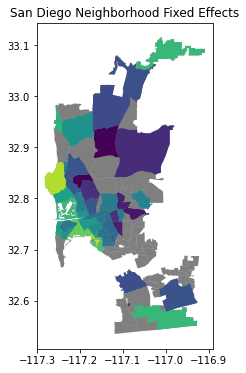

In [ ]:
ax = neighborhoods.plot(color='k', 
                        alpha=0.5,
                        figsize=(12,6))
neighborhoods.merge(neighborhood_effects, how='left',
                    left_on='neighbourhood', 
                    right_index=True)\
                  .dropna(subset=['fixed_effect'])\
                  .plot('fixed_effect',
                        ax=ax)
ax.set_title("San Diego Neighborhood Fixed Effects")
plt.show()

#### Regímenes Espaciales

En el núcleo de la estimación de efectos fijos espaciales está la idea de que, en lugar de asumir que la variable dependiente se comporta uniformemente en el espacio, existen efectos sistemáticos que siguen un patrón geográfico y afectan su comportamiento. En otras palabras, **los efectos fijos espaciales introducen econometricamente la noción de heterogeneidad espacial**. Lo hacen en la forma más simple posible: al permitir que el término constante varíe geográficamente. Los demás elementos de la regresión permanecen sin cambios y, por lo tanto, se aplican uniformemente en todo el espacio. **La idea de los regímenes espaciales (RE) es generalizar el enfoque de los efectos fijos espaciales para permitir que no solo el término constante varíe, sino también cualquier otra variable explicativa**. Esto implica que la ecuación que estaremos estimando es:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ki}\beta_{k-r} + \epsilon_i
$$

donde no solo permitimos que el término constante varíe por región ($\alpha_r$), sino también cada otro parámetro ($\beta_{k-r}$).

Para ilustrar este enfoque, usaremos el "diferenciador espacial" de si una casa está en un vecindario costero o no (`coastal_neig`) para definir los regímenes. La razón detrás de esta elección es que alquilar una casa cerca del océano podría ser un factor lo suficientemente fuerte como para que las personas estén dispuestas a pagar a diferentes *tasas* por cada una de las características de la casa.

Para implementar esto en Python, usamos la clase `OLS_Regimes` en `PySAL`, que hace la mayor parte del trabajo pesado por nosotros:


In [ ]:
m4 = spreg.OLS_Regimes(db[['log_price']].values, db[variable_names].values,
                          db['coastal'].tolist(),
                          constant_regi='many',
                          regime_err_sep=False,
                          name_y='log_price', name_x=variable_names)
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          22
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6088
R-squared           :      0.6853
Adjusted R-squared  :      0.6843
Sum squared residual:    1252.489                F-statistic           :    631.4283
Sigma-square        :       0.206                Prob(F-statistic)     :           0
S.E. of regression  :       0.454                Log likelihood        :   -3828.169
Sigma-square ML     :       0.205                Akaike info criterion :    7700.339
S.E of regression ML:      0.4528                Schwarz criterion     :    7848.128

---------------------------------------------------------

### Dependencia Espacial

Como acabamos de discutir, la heterogeneidad espacial se trata de efectos de fenómenos que están **explícitamente vinculados**
a la geografía y que, por lo tanto, causan variación espacial y agrupamiento. Esto
abarca muchos de los tipos de efectos espaciales en los que podemos estar interesados cuando ajustamos
regresiones lineales. Sin embargo, en otros casos, nuestro enfoque está en el efecto de la **configuración espacial**
de las observaciones, y en qué medida eso afecta al resultado que estamos considerando. Por ejemplo, podríamos pensar que el precio de una casa no
solo depende de si es un adosado o un apartamento, sino también de si está rodeada de muchos más adosados que rascacielos con más
apartamentos. Esto, podríamos hipotetizar, podría estar relacionado con la diferente "apariencia" que tiene un
vecindario con edificios históricos de baja altura en comparación con uno con
rascacielos modernos. En la medida en que estas dos configuraciones espaciales diferentes
entren de manera diferente en el proceso de determinación del precio de la casa, estaremos
interesados en capturar no solo las características de una casa, sino también de
las que la rodean.
Este tipo de efecto espacial es fundamentalmente diferente
de la heterogeneidad espacial en que no está relacionado con características inherentes de la geografía sino que se relaciona
con las características de las observaciones en nuestro conjunto de datos y, especialmente, con su disposición espacial. Llamamos a este fenómeno por el cual los valores de las observaciones están relacionados
entre sí a través de la distancia **dependencia espacial**.


Hay varias formas de introducir dependencia espacial en un marco econométrico, con diferentes grados de sofisticación econométrica. Común a todas ellas, sin embargo, es la forma en que el espacio está formalmente encapsulado: a través de **matrices de pesos espaciales**.

#### Regresores exógenos con rezago espacial (WX)

Volviendo al ejemplo del precio de las casas con el que hemos estado trabajando. Hasta ahora, hemos hipotetizado que el precio de una casa alquilada en San Diego a través de AirBnb puede ser explicado utilizando información sobre sus propias características así como algunas relacionadas con su ubicación, como el vecindario o la distancia al parque principal de la ciudad. Sin embargo, también es razonable pensar que los posibles inquilinos se preocupan por el área más grande alrededor de una casa, no solo por la casa en sí, y estarían dispuestos a pagar más por una casa que esté rodeada de ciertos tipos de casas, y menos si está ubicada en medio de otros tipos. ¿Cómo podríamos probar esta idea?

La forma más directa de introducir dependencia espacial en una regresión es considerando no solo una variable explicativa dada, sino también su rezago espacial. En nuestro caso de ejemplo, además de incluir un indicador para el tipo de casa, también podemos incluir el rezago espacial de cada tipo de casa. Esta adición implica que también estamos incluyendo como factor explicativo del precio de una casa dado la proporción de casas vecinas de cada tipo. Matemáticamente, esto implica estimar el siguiente modelo:

$$
\log(P_i) = \alpha + \sum^{p}_{k=1}X_{ij}\beta_j + \sum^{p}_{k=1}\left(\sum^{N}_{j=1}w_{ij}x_{jk}\right)\gamma_k + \epsilon_i
$$

donde $\sum_{j=1}^N w_{ij}x_{jk}$ representa el rezago espacial de la $k$-ésima variable explicativa. Esto se puede expresar en *forma matricial* utilizando la matriz de pesos espaciales, $\mathbf{W}$, como:
$$
\log(P_i) = \alpha + \mathbf{X}\beta + \mathbf{WX}\gamma + \epsilon
$$

Esto divide el modelo para enfocarse en dos efectos principales: $\beta$ y $\gamma$. El efecto $\beta$ describe el cambio en $y_i$ cuando $X_{ik}$ cambia en uno. Dado que usamos el precio logarítmico para una variable $y$, nuestros coeficientes $\beta$ aún se interpretan como *elasticidades*, lo que significa que un cambio de unidad en la variable $x_i$ resulta en un cambio porcentual $\beta$ en el precio *y_i*. El subíndice para el sitio $i$ es importante aquí: dado que estamos tratando con una matriz $\mathbf{W}$, es útil ser claro sobre dónde ocurre el cambio. 

De hecho, esto es importante para el efecto $\gamma$, que representa un efecto *indirecto* de un cambio en $X_i$. Esto se puede conceptualizar de dos maneras. Primero, se podría pensar en $\gamma$ simplemente como *el efecto de un cambio de unidad en sus alrededores promedio.* Esto es útil y simple. Pero, esta interpretación ignora dónde puede ocurrir este cambio. En realidad, un cambio en una variable en el sitio $i$ resultará en un *derrame* a sus alrededores: cuando $x_i$ cambia, también cambia el *rezago espacial* de cualquier sitio cerca de $i$. La precisión de esto dependerá de la estructura de $\mathbf{W}$, y puede ser diferente para cada sitio. Por ejemplo, piense en un sitio "focal" muy conectado en una matriz de pesos estandarizada por filas. Este sitio focal no se verá muy afectado si un vecino cambia por una unidad, ya que cada sitio solo contribuye en pequeña medida al rezago en el sitio focal. Alternativamente, considere un sitio con solo un vecino: su rezago cambiará *exactamente* en la cantidad que cambie su único vecino. Por lo tanto, para descubrir el efecto indirecto exacto de un cambio $y$ causado por el cambio en un sitio específico $x_i$, debería calcular el *cambio en el rezago espacial*, y luego usar eso como su *cambio* en $X$. 

En Python, podemos calcular el rezago espacial de cada variable cuyo nombre comience por `pg_` primero creando una lista con todos esos nombres, y luego aplicando `lag_spatial` de `PyS


In [ ]:
wx = db.filter(like='pg')\
        .apply(lambda y: weights.spatial_lag.lag_spatial(knn, y))\
        .rename(columns=lambda c: 'w_'+c).drop('w_pg_Apartment', axis=1)

Una vez calculado, podemos ejecutar el modelo utilizando la estimación de MCO (Mínimos Cuadrados Ordinarios) porque, en este contexto, los rezagos espaciales incluidos no violan ninguna de las suposiciones en las que se basa el MCO (son básicamente variables exógenas adicionales):


In [ ]:
slx_exog = db[variable_names].join(wx)
m5 = spreg.OLS(db[['log_price']].values, 
                  slx_exog.values,
                  name_y='l_price', 
               name_x=slx_exog.columns.tolist())
print(m5.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     l_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          15
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6095
R-squared           :      0.6800
Adjusted R-squared  :      0.6792
Sum squared residual:    1273.933                F-statistic           :    924.9423
Sigma-square        :       0.209                Prob(F-statistic)     :           0
S.E. of regression  :       0.457                Log likelihood        :   -3880.030
Sigma-square ML     :       0.208                Akaike info criterion :    7790.061
S.E of regression ML:      0.4566                Schwarz criterion     :    7890.826

-----------------------------------------------------------------------------

La forma de interpretar la tabla de resultados es similar a la de cualquier otra regresión no espacial. Las variables que incluimos en la regresión original muestran un comportamiento similar, aunque con pequeños cambios en tamaño, y también pueden interpretarse de manera similar. El rezago espacial de cada tipo de propiedad (`w_pg_XXX`) es la nueva adición. Observamos que, excepto en el caso de las casas adosadas (igual que con la variable binaria, `pg_Townhouse`), todas son significativas, lo que sugiere que nuestra hipótesis inicial sobre el papel de las casas circundantes podría estar funcionando aquí.

Como ilustración, veamos algunos de los efectos directos/indirectos.
El efecto directo de la variable `pg_Condominium` significa que los condominios suelen ser un 11% más caros ($\beta_{pg\_Condominium}=0.1063$) que el tipo de propiedad de referencia, los apartamentos. Más relevante para esta sección, cualquier casa dada rodeada de condominios *también* recibe un precio premium. Pero, como $pg_Condominium$ es una variable dummy, el rezago espacial en el sitio $i$ representa el *porcentaje* de propiedades cerca de $i$ que son condominios, que está entre $0$ y $1$.
Entonces, un cambio *unitario* en esta variable significa que aumentaría el porcentaje de condominios en un 100%. Por lo tanto, un aumento de $0.1$ en `w_pg_Condominium` (un cambio de diez puntos porcentuales) resultaría en un aumento del 5.92% en el precio de la casa ($\beta_{w_pg\_Condominium} = 0.6$).
Se pueden derivar interpretaciones similares para todos los demás variables con rezago espacial para derivar el efecto *indirecto* de un cambio en el rezago espacial.

Sin embargo, para calcular el cambio indirecto para un sitio dado $i$, es posible que necesite examinar los valores predichos para $y_i$. En este ejemplo, dado que estamos utilizando una matriz de pesos estandarizada por filas con veinte vecinos más cercanos, el impacto de cambiar $x_i$ es el mismo para todos sus vecinos y para cualquier sitio $i$. Por lo tanto, el efecto siempre es $\frac{\gamma}{20}$, o aproximadamente $0.0296$. Sin embargo, esto no sería lo mismo para muchos otros tipos de pesos (como `Kernel`, `Queen`, `Rook`, `DistanceBand` o `Voronoi`), por lo que demostraremos cómo construir el efecto indirecto para un $i$ específico:

Primero, los valores predichos para $y_i$ se almacenan en el atributo `predy` de cualquier modelo:


In [ ]:
m5.predy

array([[5.43610121],
       [5.38596868],
       [4.25377454],
       ...,
       [4.29145318],
       [4.89174746],
       [4.85867698]])

Para construir nuevas predicciones, necesitamos seguir la ecuación mencionada anteriormente.

Mostrando este proceso a continuación, primero cambiemos una propiedad para que sea un condominio. Consideremos la tercera observación, que es el primer apartamento en los datos:


In [ ]:
db.loc[2]

accommodates                                                     2
bathrooms                                                 1.000000
bedrooms                                                  1.000000
beds                                                      1.000000
neighborhood                                           North Hills
pool                                                             0
d2balboa                                                  2.493893
coastal                                                          0
price                                                    99.000000
log_price                                                 4.595120
id                                                            9553
pg_Apartment                                                     1
pg_Condominium                                                   0
pg_House                                                         0
pg_Other                                                      

Este es un apartamento. Hagamos una copia de nuestros datos y cambiemos este apartamento por un condominio:


In [ ]:
db_scenario = db.copy()
db_scenario.loc[2, ['pg_Apartment', 'pg_Condominium']] = [0,1] # make Apartment 0 and condo 1

Hemos realizado el cambio con éxito:


In [ ]:
db_scenario.loc[2]

accommodates                                                     2
bathrooms                                                        1
bedrooms                                                         1
beds                                                             1
neighborhood                                           North Hills
pool                                                             0
d2balboa                                                   2.49389
coastal                                                          0
price                                                           99
log_price                                                  4.59512
id                                                            9553
pg_Apartment                                                     0
pg_Condominium                                                   1
pg_House                                                         0
pg_Other                                                      

Ahora, también necesitamos actualizar las variables de rezago espacial:


In [ ]:
wx_scenario = db_scenario.filter(like='pg')\
                         .apply(lambda y: weights.spatial_lag.lag_spatial(knn, y))\
                         .rename(columns=lambda c: 'w_'+c).drop('w_pg_Apartment', axis=1)

Y construir una nueva matriz exógena $\mathbf{X}$, incluyendo una constante 1 como la columna principal


In [ ]:
slx_exog_scenario = db_scenario[variable_names].join(wx_scenario)

Ahora, nuestra nueva predicción (en el escenario donde hemos cambiado el sitio `2` de un apartamento a un condominio) es:


In [ ]:
y_pred_scenario = m5.betas[0] + slx_exog_scenario @ m5.betas[1:]

Esta predicción será exactamente la misma para todos los sitios, excepto el sitio `2` y sus vecinos. Entonces, los *vecinos* del sitio `2` son:


In [ ]:
knn.neighbors[2]

[772,
 2212,
 139,
 4653,
 2786,
 1218,
 138,
 808,
 1480,
 4241,
 1631,
 3617,
 2612,
 1162,
 135,
 23,
 5528,
 3591,
 407,
 6088]

Y el efecto de cambiar el sitio `2` a un condominio se asocia con los siguientes cambios en $y_i$:


In [ ]:
(y_pred_scenario - m5.predy).loc[[2] + knn.neighbors[2]]

,0
2,0.106349
772,0.029642
2212,0.029642
139,0.029642
4653,0.029642
2786,0.029642
1218,0.029642
138,0.029642
808,0.029642
1480,0.029642


Vemos que la primera fila, que representa el efecto directo, es igual exactamente a la estimación para `pg_Condominium`. Sin embargo, para los otros efectos, solo hemos cambiado `w_pg_Condominium` en $0.05$.


In [ ]:
scenario_near_2 = slx_exog_scenario.loc[knn.neighbors[2], ['w_pg_Condominium']]
orig_near_2 = slx_exog.loc[knn.neighbors[2], ['w_pg_Condominium']]
scenario_near_2.join(orig_near_2, lsuffix='_scenario', rsuffix= '_original')

,w_pg_Condominium_scenario,w_pg_Condominium_original
772,0.10,0.05
2212,0.10,0.05
139,0.10,0.05
4653,0.10,0.05
2786,0.10,0.05
1218,0.10,0.05
138,0.10,0.05
808,0.05,0.00
1480,0.10,0.05
4241,0.10,0.05


Introducir un retraso espacial de una variable explicativa, como acabamos de ver, es la forma más sencilla de incorporar la noción de dependencia espacial en un marco de regresión lineal. No requiere cambios adicionales, puede estimarse con OLS y la interpretación es bastante similar a la de interpretar variables no espaciales, siempre que se requieran cambios agregados.

Sin embargo, el campo de la econometría espacial es mucho más amplio y ha producido en las últimas décadas muchas técnicas para tratar los efectos espaciales y la dependencia espacial de diferentes maneras. Aunque esto puede ser una simplificación excesiva, se puede decir que la mayoría de esos esfuerzos para el caso de una sola sección transversal se centran en dos variaciones principales: el modelo de retraso espacial y el modelo de error espacial. Ambos son similares al caso que hemos visto en que se basan en la introducción de un retraso espacial, pero difieren en el componente del modelo que modifican y afectan.

#### Modelo de error espacial

El modelo de error espacial incluye un retraso espacial en el término de error de la ecuación:

$$
\log{P_i} = \alpha + \sum_k \beta_k X_{ki} + u_i
$$

$$
u_i = \lambda u_{lag-i} + \epsilon_i
$$

donde $u_{lag-i} = \sum_j w_{i,j} u_j$.
Aunque parece similar, esta especificación viola las suposiciones sobre el término de error en un modelo OLS clásico. Por lo tanto, se requieren métodos de estimación alternativos. `PySAL` incorpora funcionalidad para estimar varios de los métodos más avanzados desarrollados por la literatura sobre econometría espacial. Por ejemplo, podemos usar un método general de momentos que tenga en cuenta la heterogeneidad (Arraiz et al., 2010):


In [ ]:
m6 = spreg.GM_Error_Het(db[['log_price']].values, db[variable_names].values,
                           w=knn, name_y='log_price', name_x=variable_names)
print(m6.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
Pseudo R-squared    :      0.6655
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.4262033       0.0217088     203.8898738       0.0000000
        accommodates       0.0695536       0.0063268      10.9934495       0.00

#### Modelo de Autoregresión espacial

El modelo de retraso espacial introduce un retraso espacial de la variable *dependiente*. En el ejemplo que hemos cubierto, esto se traduciría en:

$$
\log{P_i} = \alpha + \rho \log{P_{lag-i}} + \sum_k \beta_k X_{ki} + \epsilon_i
$$

Aunque puede no parecer muy diferente de la ecuación anterior, este modelo viola la suposición de exogeneidad, crucial para que funcione OLS.
En pocas palabras, esto ocurre cuando $P_i$ existe en ambos "lados" del signo igual.
En teoría, dado que $P_i$ se incluye en el cálculo de $P_{lag-i}$, se viola la exogeneidad.
Al igual que en el caso del error espacial, se han propuesto varias técnicas para superar esta limitación y `PySAL` implementa varias de ellas. En el ejemplo a continuación, utilizamos una estimación de mínimos cuadrados en dos etapas Anselin (1988), donde el retraso espacial de todas las variables explicativas se utiliza como instrumento para el retraso endógeno:


In [ ]:
m7 = spreg.GM_Lag(db[['log_price']].values, db[variable_names].values,
                     w=knn, name_y='log_price', name_x=variable_names)
print(m7.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          12
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6098
Pseudo R-squared    :      0.7057
Spatial Pseudo R-squared:  0.6883

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       2.7440254       0.0727290      37.7294400       0.0000000
        accommodates       0.0697596       0.0048157      14.4859187       0.0000000
           bathrooms       0.1626725       0.0104007      1

#### Otras formas de incorporar el espacio en la regresión

Si bien estas son algunas formas de regresiones espaciales, muchos otros métodos avanzados de regresión espacial se utilizan habitualmente en estadística, ciencia de datos y análisis aplicado. Por ejemplo, los Modelos Aditivos Generalizados {cite}`Gibbons_2015,Wood_2006` se han utilizado para aplicar suavizado de núcleo espacial directamente dentro de una función de regresión. Otros métodos de suavizado similares, como los modelos de proceso gaussiano espacial {cite}`Brunsdon_2010` o Kriging, conceptualizan la dependencia entre ubicaciones también como suave. Otros métodos en regresión espacial que consideran geografías basadas en grafos (en lugar de efectos de distancia/núcleo) incluyen variaciones del modelo autorregresivo condicional, que examina las relaciones espaciales en ubicaciones *condicionales* a su entorno, en lugar de como co-emergentes con ellos. Sin embargo, la cobertura completa de estos temas está fuera del alcance de este libro, aunque {cite}`Banerjee_2008` proporciona una discusión detallada y completa.


### Challenge

#### La costa aleatoria
En la sección donde analizamos los residuos de nuestro modelo ingenuo, realizamos una prueba $t$ de dos muestras clásica para identificar si los distritos residenciales costeros y no costeros tendían a tener los mismos errores de predicción. Sin embargo, a menudo es mejor utilizar métodos de prueba y simulación directos y basados en datos que asumir que se cumplen las suposiciones matemáticas de la estadística $t$.

Para hacer esto, podemos mezclar nuestras asignaciones a costa y no costa, y comprobar si hay diferencias en las distribuciones de los residuos *observados* y las distribuciones aleatorias. De esta manera, mezclamos las observaciones que están en la costa y trazamos las distribuciones acumulativas resultantes.

A continuación, hacemos esto; ejecutando 100 reasignaciones simuladas de distritos a "costa" o "no costa" y comparando las distribuciones de los residuos asignados aleatoriamente con las distribuciones observadas de residuos. Además, hacemos este trazado mediante la *función de densidad acumulativa empírica*, no directamente el histograma. Esto se debe a que la *función de densidad acumulativa empírica* suele ser más fácil de examinar visualmente, especialmente para diferencias sutiles.

A continuación, las líneas negras representan nuestras simulaciones, y los parches de colores debajo de ellas representan la distribución observada de residuos. Si las líneas negras tienden a estar a la izquierda del parche de color, entonces las simulaciones (donde el error de predicción es totalmente aleatorio con respecto a nuestras categorías de "costa" y "no costa") tienden a tener más residuos negativos que nuestro modelo real. Si las líneas negras tienden a estar a la derecha, entonces tienden a tener más residuos positivos. Como recordatorio, los residuos positivos significan que nuestro modelo está subestimando, y los residuos negativos significan que nuestro modelo está sobreestimando. A continuación, nuestras simulaciones proporcionan evidencia directa de que nuestro modelo puede estar sistemáticamente subestimando el precio de la costa y sobreestimando los precios no costeros.


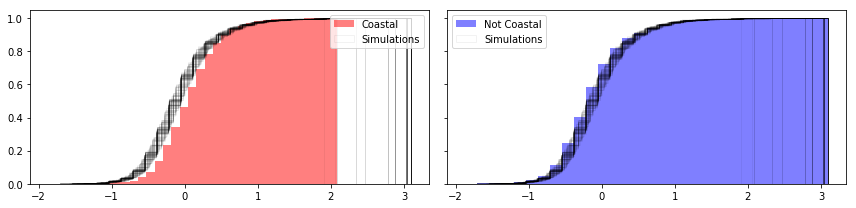

In [ ]:
n_simulations = 100
f, ax = plt.subplots(1,2,figsize=(12,3), sharex=True, sharey=True)
ax[0].hist(coastal, color='r', alpha=.5, 
           density=True, bins=30, label='Coastal', 
           cumulative=True)
ax[1].hist(not_coastal, color='b', alpha=.5,
           density=True, bins=30, label='Not Coastal', 
           cumulative=True)
for simulation in range(n_simulations):
    shuffled_residuals = m1.u[numpy.random.permutation(m1.n)]
    random_coast, random_notcoast = (shuffled_residuals[is_coastal], 
                                     shuffled_residuals[~is_coastal])
    if simulation == 0:
        label = 'Simulations'
    else:
        label = None
    ax[0].hist(random_coast, 
                density=True, 
                histtype='step',
                color='k', alpha=.05, bins=30, 
                label=label, 
                cumulative=True)
    ax[1].hist(random_coast, 
                density=True, 
                histtype='step',
                color='k', alpha=.05, bins=30, 
                label=label, 
                cumulative=True)
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

#### El correlograma de vecinos K

Además, puede ser el caso que la dependencia espacial en nuestras predicciones erróneas solo importe para sitios que están extremadamente cerca uno del otro, y decae rápidamente con la distancia. Para investigar esto, podemos examinar la correlación entre el residuo de cada sitio y el *promedio* de los residuos de los $k$ vecinos más cercanos, aumentando $k$ hasta que la estimación se estabilice. Esta idea principal es central para el concepto geoestadístico, el *correlograma*, que muestra la correlación entre los sitios de un atributo en estudio a medida que aumenta la distancia.

Una forma rápida de comprobar si lo que hemos visto es *único* o *significativo* es compararlo con lo que sucede cuando simplemente asignamos vecinos al azar. Si lo que observamos es sustancialmente diferente de lo que emerge cuando los vecinos son aleatorios, entonces la estructura de los vecinos incorpora una estructura en los residuos. No nos detendremos demasiado en esta teoría específicamente, pero podemos calcular de manera rápida y eficiente la correlación entre nuestros residuos observados y el retraso espacial de un conjunto creciente de $k$ vecinos más cercanos:


In [ ]:
correlations = []
nulls = []
for order in range(1, 51, 5):
    knn.reweight(k=order, inplace=True) #operates in place, quickly and efficiently avoiding copies
    knn.transform = 'r'
    lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
    random_residual = m1.u[numpy.random.permutation(len(m1.u))] 
    random_lag_residual = weights.spatial_lag.lag_spatial(knn, random_residual) # identical to random neighbors in KNN 
    correlations.append(numpy.corrcoef(m1.u.flatten(), lag_residual.flatten())[0,1])
    nulls.append(numpy.corrcoef(m1.u.flatten(), random_lag_residual.flatten())[0,1])

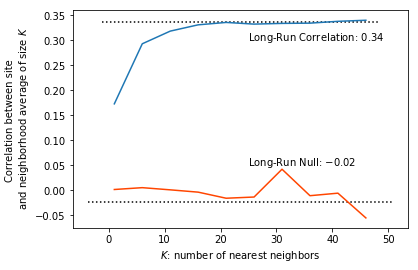

In [ ]:
plt.plot(range(1,51,5), correlations)
plt.plot(range(1,51,5), nulls, color='orangered')
plt.hlines(numpy.mean(correlations[-3:]),*plt.xlim(),linestyle=':', color='k')
plt.hlines(numpy.mean(nulls[-3:]),*plt.xlim(),linestyle=':', color='k')
plt.text(s='Long-Run Correlation: ${:.2f}$'.format(numpy.mean(correlations[-3:])), x=25,y=.3)
plt.text(s='Long-Run Null: ${:.2f}$'.format(numpy.mean(nulls[-3:])), x=25, y=.05)
plt.xlabel('$K$: number of nearest neighbors')
plt.ylabel("Correlation between site \n and neighborhood average of size $K$")
plt.show()

Claramente, las dos curvas son diferentes. La correlación observada alcanza un pico alrededor de $r=.34$ cuando se utilizan alrededor de 20 listados más cercanos. Esto significa que agregar más de 20 vecinos más cercanos no cambia significativamente la correlación en los residuos. Además, la correlación más baja es para el vecino más cercano único, y la correlación aumenta rápidamente a medida que se agregan más vecinos cerca del listado. Por lo tanto, esto significa que parece haber una estructura espacial no medida en los residuos, ya que son más similares entre sí cuando están cerca que cuando están separados. Además, aunque no se muestra aquí (ya que computacionalmente se vuelve inmanejable), a medida que el número de vecinos más cercanos se vuelve muy grande (aproximándose al número de observaciones en el conjunto de datos), el promedio de los residuos del $k$-ésimo vecino más cercano tiende a cero, el promedio global de residuos. Esto significa que la correlación de los residuos y un vector que es casi constante tiende a acercarse a cero.

Las correlaciones nulas, sin embargo, utilizan vecinos elegidos al azar (sin reasignación). Por lo tanto, dado que el muestreo es verdaderamente aleatorio en este caso, cada promedio de $k$ vecinos elegidos al azar suele ser cero (la media global). Entonces, la correlación entre el residuo observado y el promedio de los residuos elegidos aleatoriamente $k$ también suele ser cero. Por lo tanto, aumentar el número de vecinos elegidos al azar no ajusta significativamente el promedio a largo plazo de cero. En conjunto, podemos concluir que hay una dependencia espacial positiva distintiva en el error. Esto significa que nuestras sobreestimaciones y subestimaciones es probable que se agrupen.


## Geographically Weighted Regression

In [ ]:
import libpysal as ps

In [ ]:
ps.examples.explain('GData_utm')

In [ ]:
georgia_data = pd.read_csv(ps.examples.get_path('GData_utm.csv'))
georgia_shp = gpd.read_file(ps.examples.get_path('G_utm.shp'))

<AxesSubplot:>

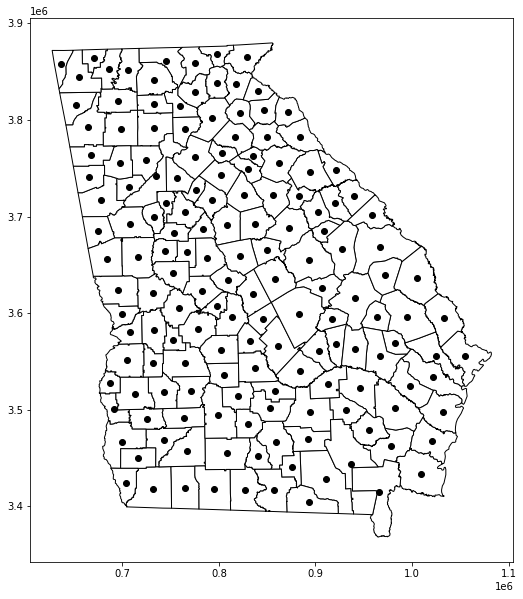

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
georgia_shp.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
georgia_shp.centroid.plot(ax=ax, c='black')

In [ ]:
georgia_shp.head(2)

,AREA,PERIMETER,G_UTM_,G_UTM_ID,Latitude,Longitud,TotPop90,PctRural,PctBach,PctEld,PctFB,PctPov,PctBlack,X,Y,AreaKey,geometry
0,1.331370e+09,207205.0,132,133,31.75339,-82.28558,15744,75.6,8.2,11.43,0.64,19.9,20.76,941396.6,3521764,13001,"POLYGON ((931869.062 3545540.500, 934111.625 3..."
1,8.929300e+08,154640.0,157,158,31.29486,-82.87474,6213,100.0,6.4,11.77,1.58,26.0,26.86,895553.0,3471916,13003,"POLYGON ((867016.312 3482416.000, 884309.375 3..."


In [ ]:
georgia_shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   AREA       159 non-null    float64 
 1   PERIMETER  159 non-null    float64 
 2   G_UTM_     159 non-null    int64   
 3   G_UTM_ID   159 non-null    int64   
 4   Latitude   159 non-null    float64 
 5   Longitud   159 non-null    float64 
 6   TotPop90   159 non-null    int64   
 7   PctRural   159 non-null    float64 
 8   PctBach    159 non-null    float64 
 9   PctEld     159 non-null    float64 
 10  PctFB      159 non-null    float64 
 11  PctPov     159 non-null    float64 
 12  PctBlack   159 non-null    float64 
 13  X          159 non-null    float64 
 14  Y          159 non-null    int64   
 15  AreaKey    159 non-null    int64   
 16  geometry   159 non-null    geometry
dtypes: float64(11), geometry(1), int64(5)
memory usage: 21.2 KB


In [ ]:
#Prepare Georgia dataset inputs
g_y = georgia_data['PctBach'].values.reshape((-1,1))
g_X = georgia_data[['PctFB', 'PctBlack', 'PctRural']].values
u = georgia_data['X']
v = georgia_data['Y']
g_coords = list(zip(u,v))


In [ ]:
# estandarizar datos
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = g_y.reshape((-1,1))
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [ ]:
#Calibrate GWR model
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)

117.0


In [ ]:
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

In [ ]:
import numpy as np
np.shape(gwr_results.params)

(159, 4)

In [ ]:
gwr_results.params[0:5]

array([[-0.23204579,  0.22820815,  0.05697445, -0.42649461],
       [-0.2792238 ,  0.16511734,  0.09516542, -0.41226348],
       [-0.248944  ,  0.20466991,  0.07121197, -0.42573638],
       [-0.23036768,  0.1527493 ,  0.0510379 , -0.35938659],
       [ 0.19066196,  0.71627541, -0.16920186, -0.24091753]])

In [ ]:
gwr_results.localR2[0:10]

array([[0.55932878],
       [0.5148705 ],
       [0.54751792],
       [0.50691577],
       [0.69062134],
       [0.69429812],
       [0.69813709],
       [0.70867337],
       [0.49985703],
       [0.49379842]])

In [ ]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 159
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             71.793
Log-likelihood:                                                    -162.399
AIC:                                                                332.798
AICc:                                                               335.191
BIC:                                                               -713.887
R2:                                                                   0.548
Adj. R2:                                                              0.540

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
#Prepare GWR results for mapping

#Add GWR parameters to GeoDataframe
georgia_shp['gwr_intercept'] = gwr_results.params[:,0]
georgia_shp['gwr_fb'] = gwr_results.params[:,1]
georgia_shp['gwr_aa'] = gwr_results.params[:,2]
georgia_shp['gwr_rural'] = gwr_results.params[:,3]

#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

<AxesSubplot:>

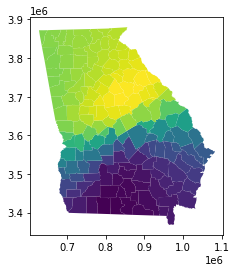

In [ ]:
georgia_shp.plot(column='gwr_intercept')

<AxesSubplot:>

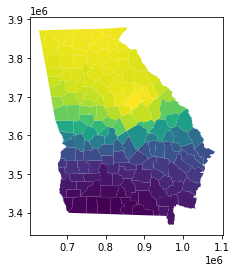

In [ ]:
georgia_shp.plot(column='gwr_fb')

<AxesSubplot:>

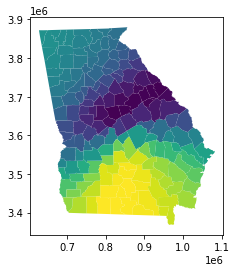

In [ ]:
georgia_shp.plot(column='gwr_aa')

<AxesSubplot:>

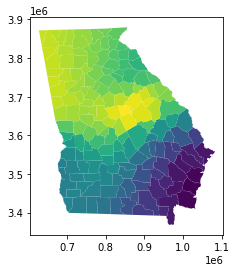

In [ ]:
georgia_shp.plot(column='gwr_rural')

### Multiscale Geographically Weighted Regression (MGWR)

In [ ]:
#Calibrate MGWR model

mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[ 92. 101. 136. 158.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 159
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             71.793
Log-likelihood:                                                    -162.399
AIC:                                                                332.798
AICc:                                                               335.191
BIC:                                                               -713.887
R2:                                                                   0.548
Adj. R2:                                                              0.540

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
#Prepare MGWR results for mapping

#Add MGWR parameters to GeoDataframe
georgia_shp['mgwr_intercept'] = mgwr_results.params[:,0]
georgia_shp['mgwr_fb'] = mgwr_results.params[:,1]
georgia_shp['mgwr_aa'] = mgwr_results.params[:,2]
georgia_shp['mgwr_rural'] = mgwr_results.params[:,3]

#Obtain t-vals filtered based on multiple testing correction
mgwr_filtered_t = mgwr_results.filter_tvals()

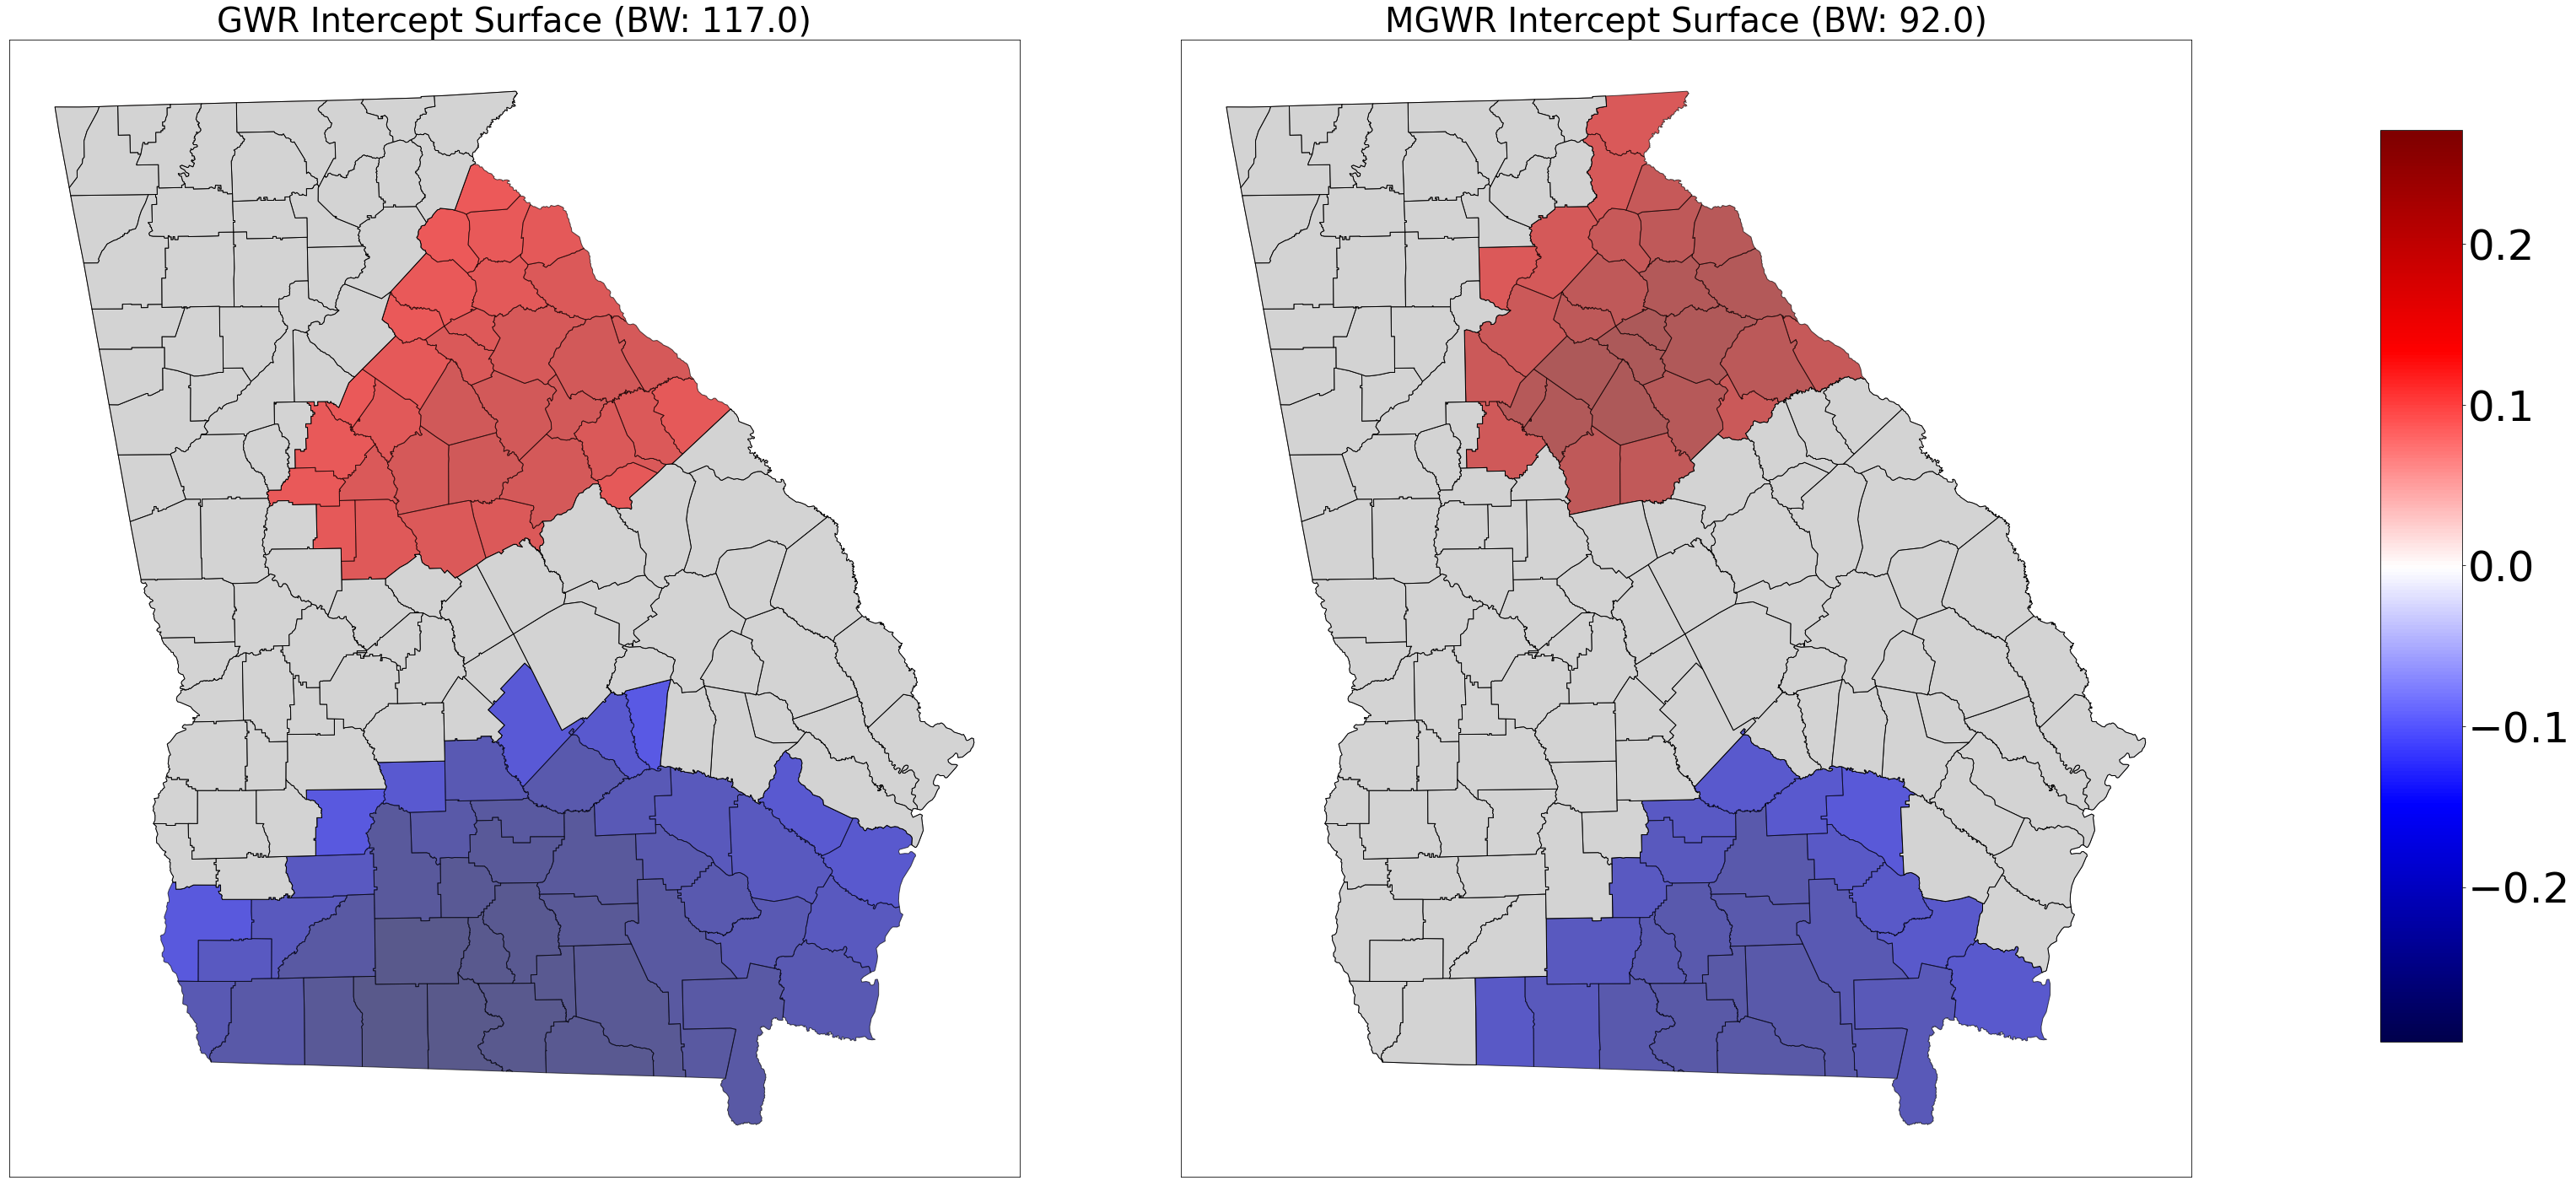

In [ ]:
#Comparison maps of GWR vs. MGWR parameter surfaces where the grey units pertain to statistically insignificant parameters

from mgwr.utils import shift_colormap, truncate_colormap

#Prep plot and add axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Intercept Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Intercept Surface (BW: ' + str(mgwr_bw[0]) +')', fontsize=40)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the two combined datasets
gwr_min = georgia_shp['gwr_intercept'].min()
gwr_max = georgia_shp['gwr_intercept'].max()
mgwr_min = georgia_shp['mgwr_intercept'].min()
mgwr_max = georgia_shp['mgwr_intercept'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

#If all values are negative use the negative half of the colormap
if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
#If all values are positive use the positive half of the colormap
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
#Otherwise, there are positive and negative values so the colormap so zero is the midpoint
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
georgia_shp.plot('gwr_intercept', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (gwr_filtered_t[:,0] == 0).any():
    georgia_shp[gwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

#Plot MGWR parameters
georgia_shp.plot('mgwr_intercept', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
#If there are insignificnt parameters plot gray polygons over them
if (mgwr_filtered_t[:,0] == 0).any():
    georgia_shp[mgwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})
 
#Set figure options and plot 
fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

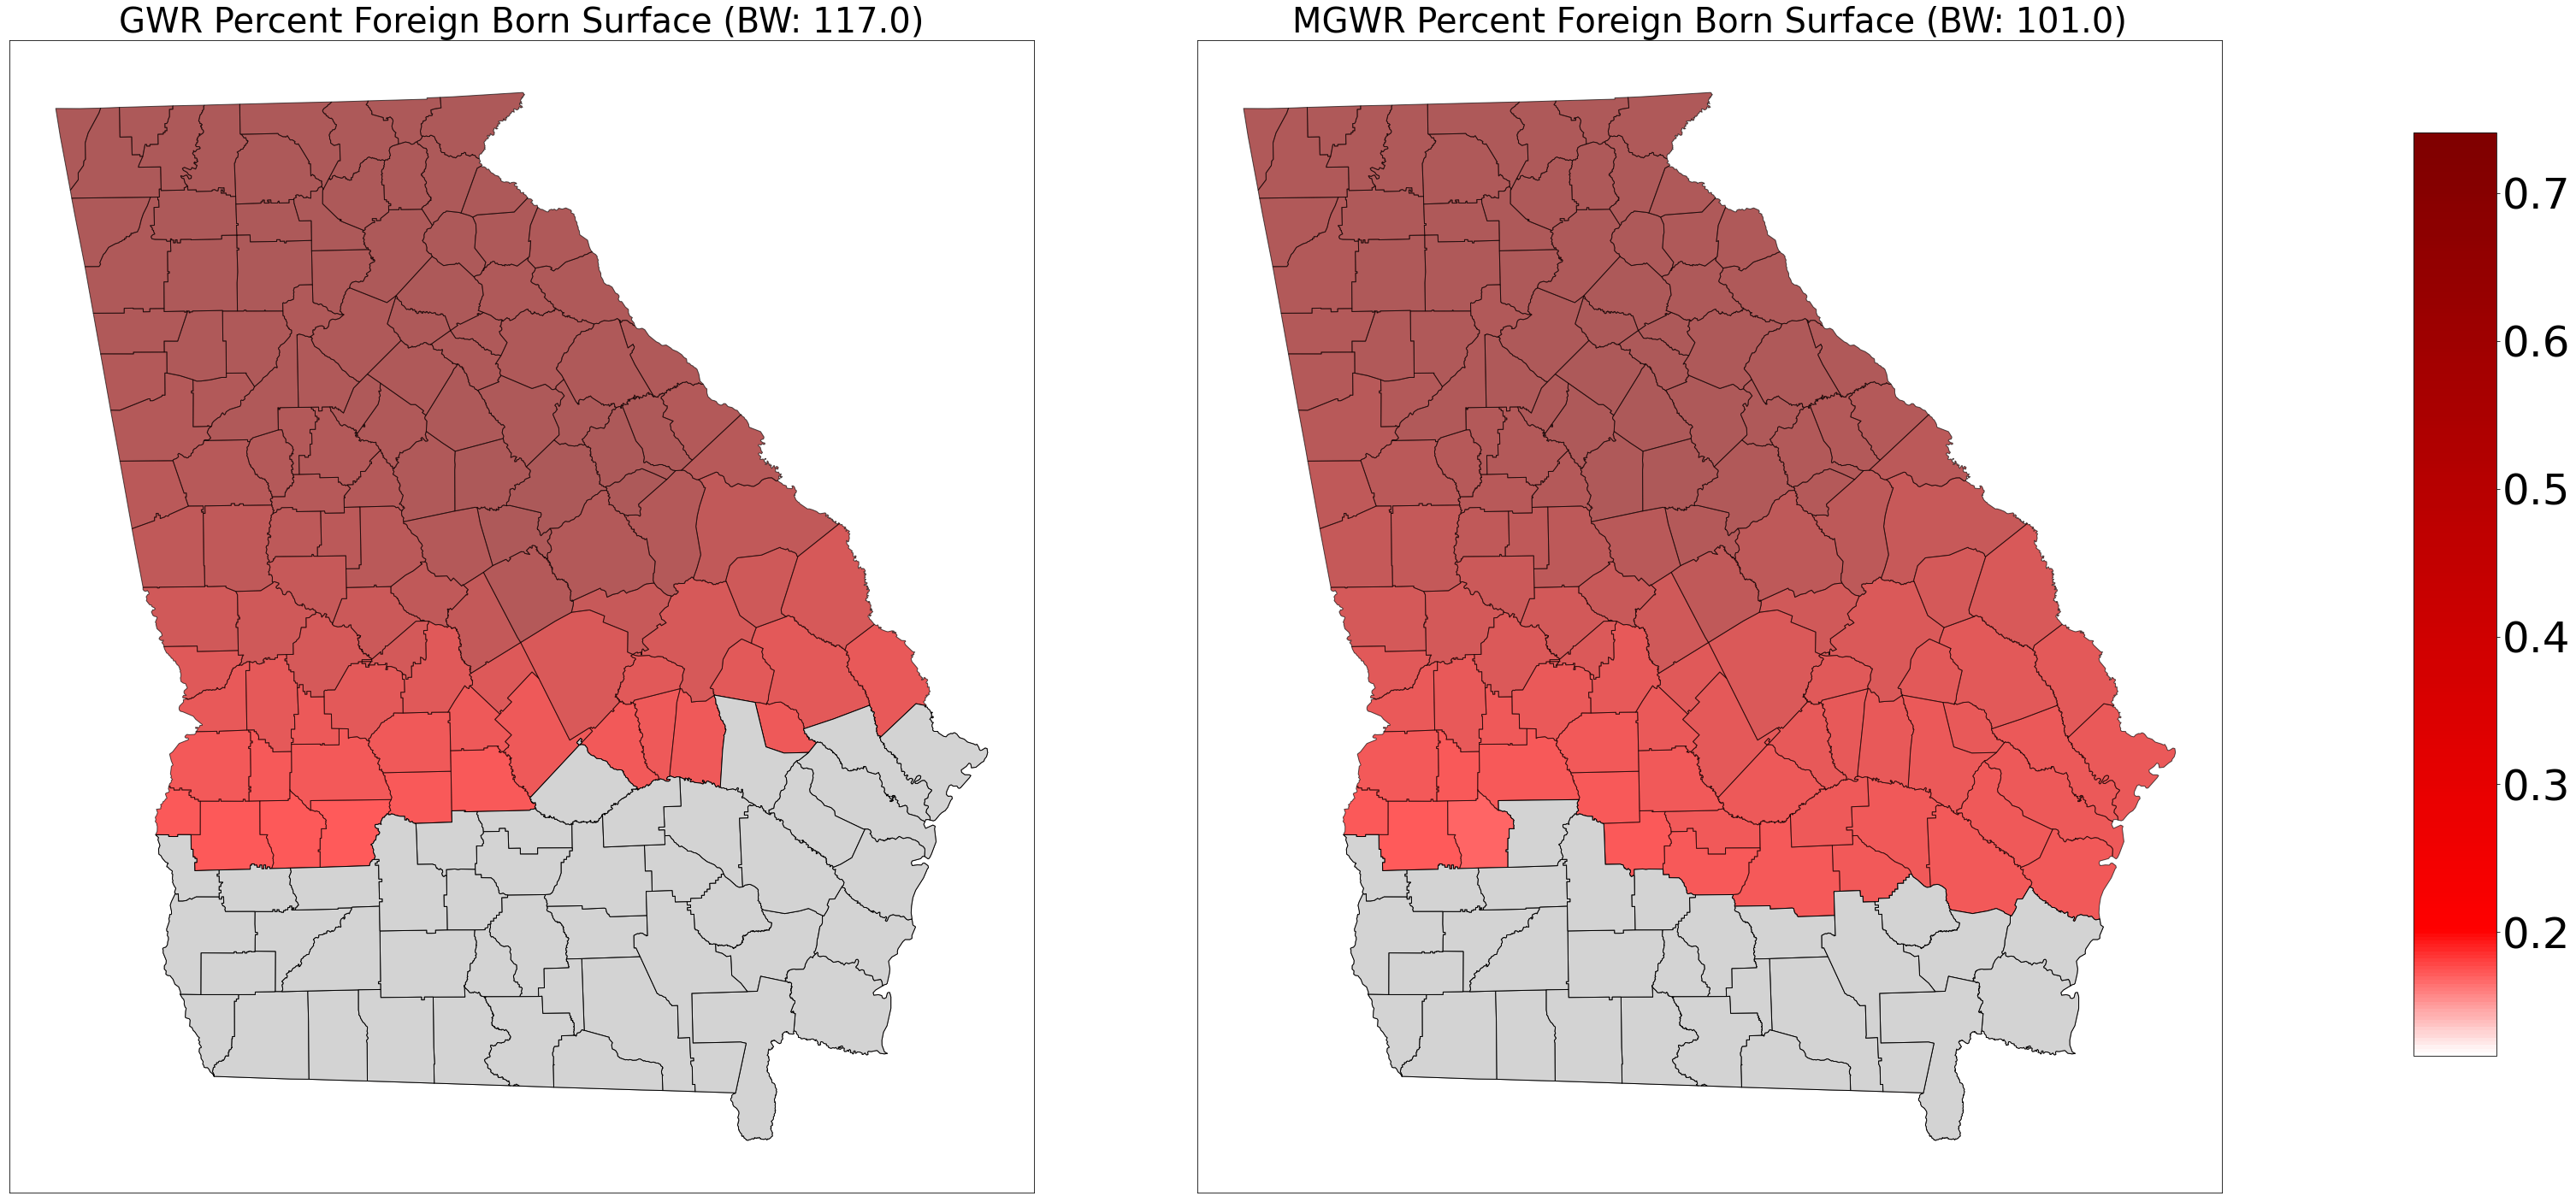

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Percent Foreign Born Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Percent Foreign Born Surface (BW: ' + str(mgwr_bw[1]) +')', fontsize=40)
cmap = plt.cm.seismic
gwr_min = georgia_shp['gwr_fb'].min()
gwr_max = georgia_shp['gwr_fb'].max()
mgwr_min = georgia_shp['mgwr_fb'].min()
mgwr_max = georgia_shp['mgwr_fb'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)

cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

georgia_shp.plot('gwr_fb', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,1] == 0).any():
    georgia_shp[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

georgia_shp.plot('mgwr_fb', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (mgwr_filtered_t[:,1] == 0).any():
    georgia_shp[mgwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})
    
fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

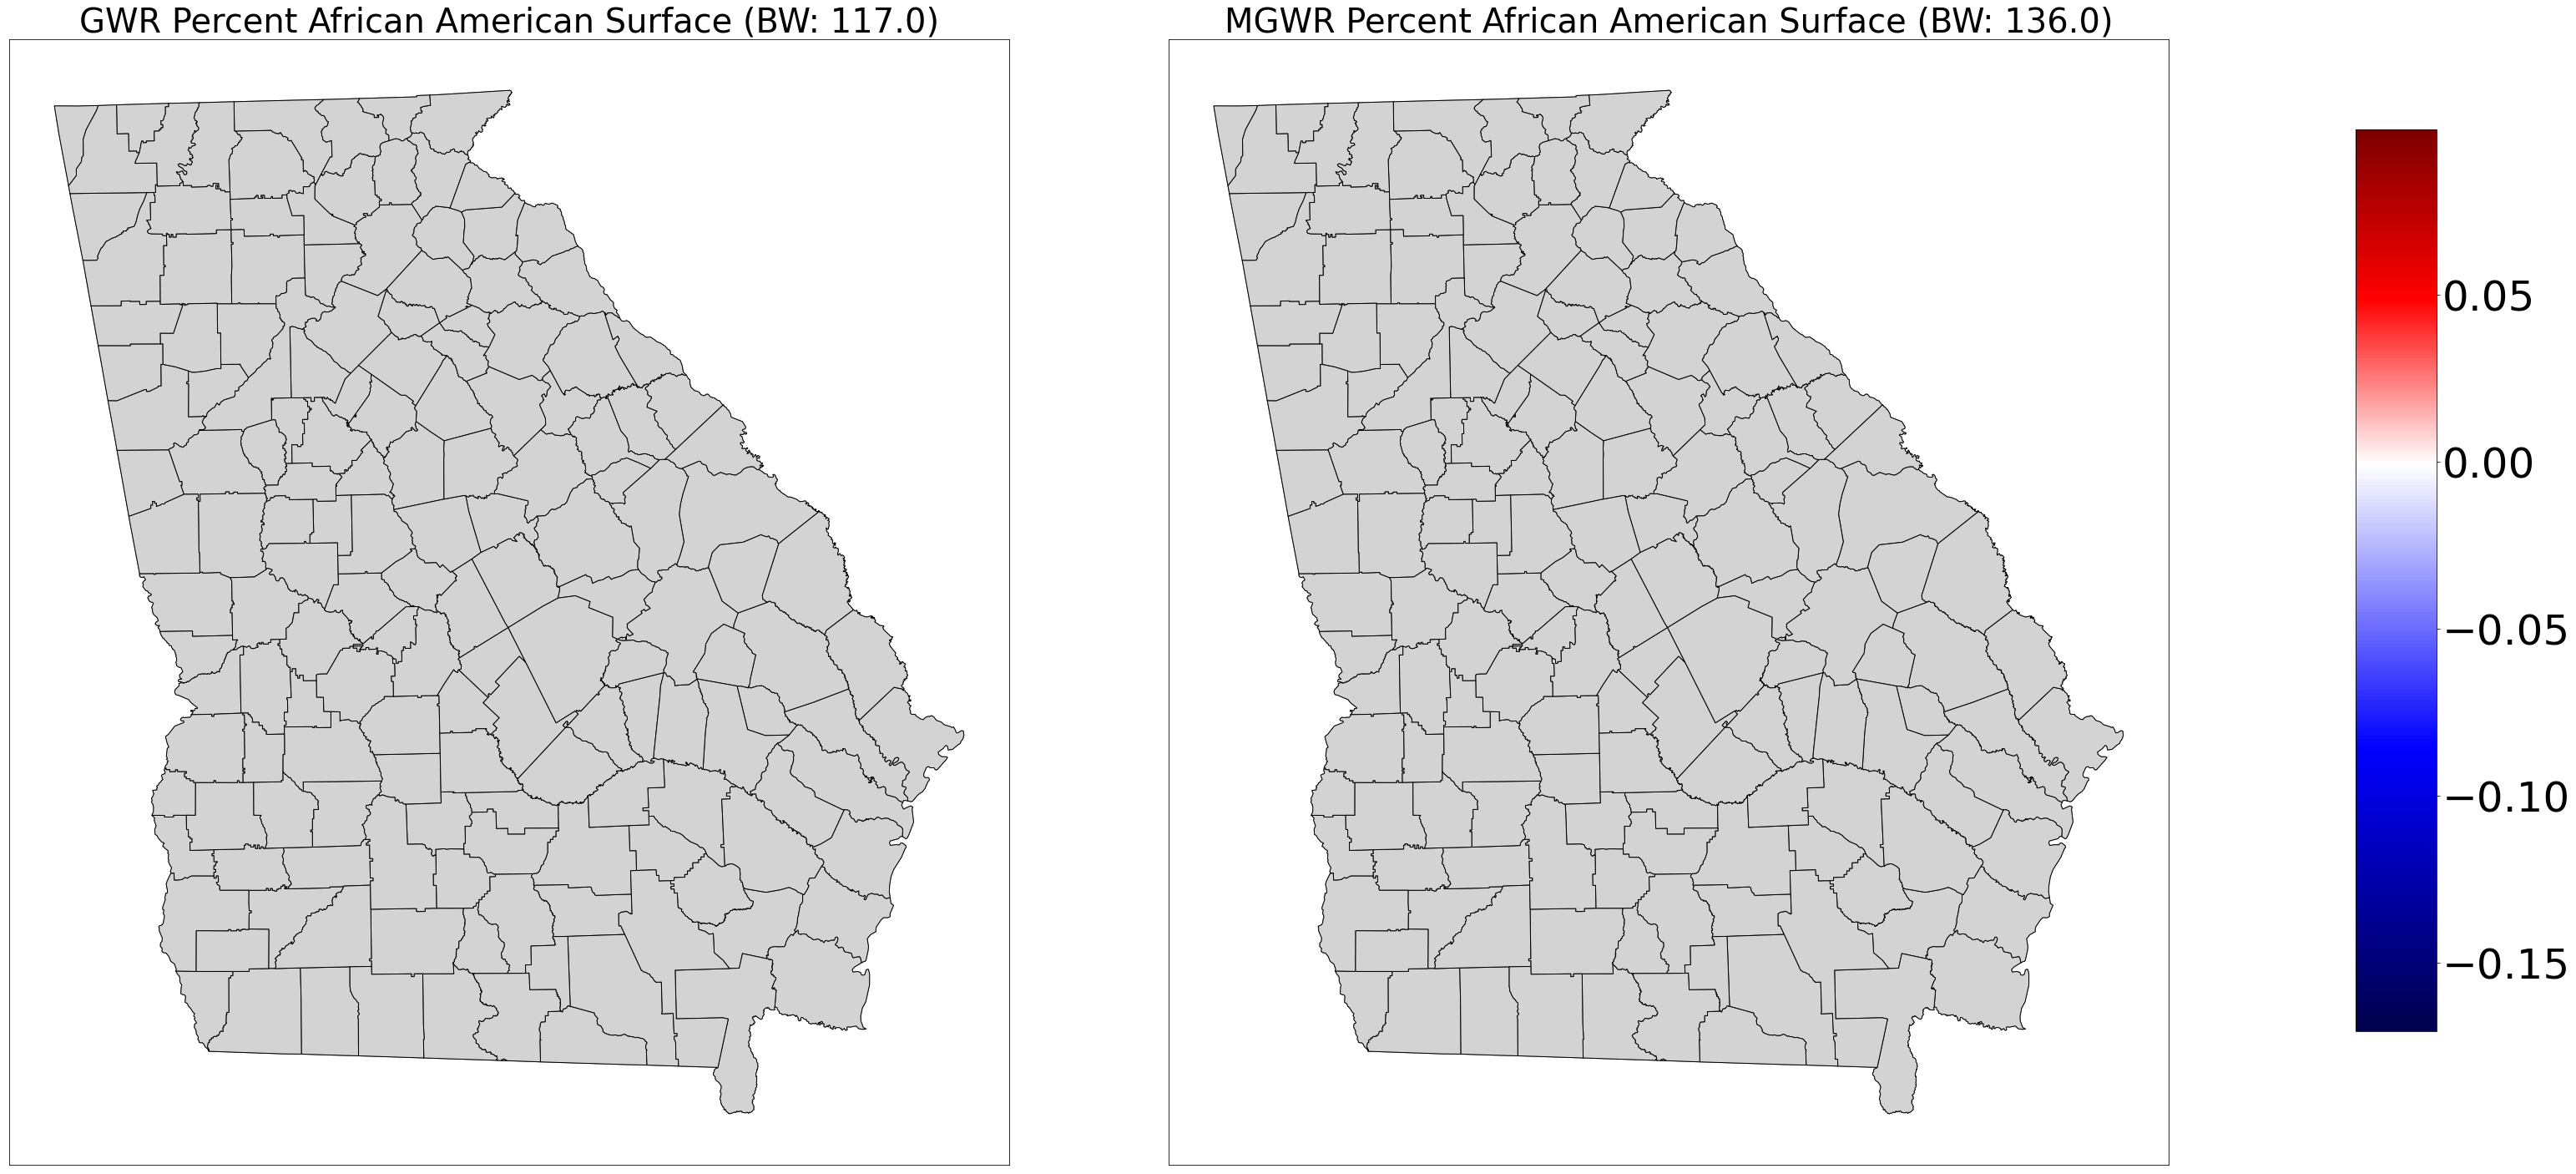

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Percent African American Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Percent African American Surface (BW: ' + str(mgwr_bw[2]) +')', fontsize=40)
cmap = plt.cm.seismic
gwr_min = georgia_shp['gwr_aa'].min()
gwr_max = georgia_shp['gwr_aa'].max()
mgwr_min = georgia_shp['mgwr_aa'].min()
mgwr_max = georgia_shp['mgwr_aa'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

georgia_shp.plot('gwr_aa', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,2] == 0).any():
    georgia_shp[gwr_filtered_t[:,2] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

georgia_shp.plot('mgwr_aa', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (mgwr_filtered_t[:,2] == 0).any():
    georgia_shp[mgwr_filtered_t[:,2] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})
    
fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()

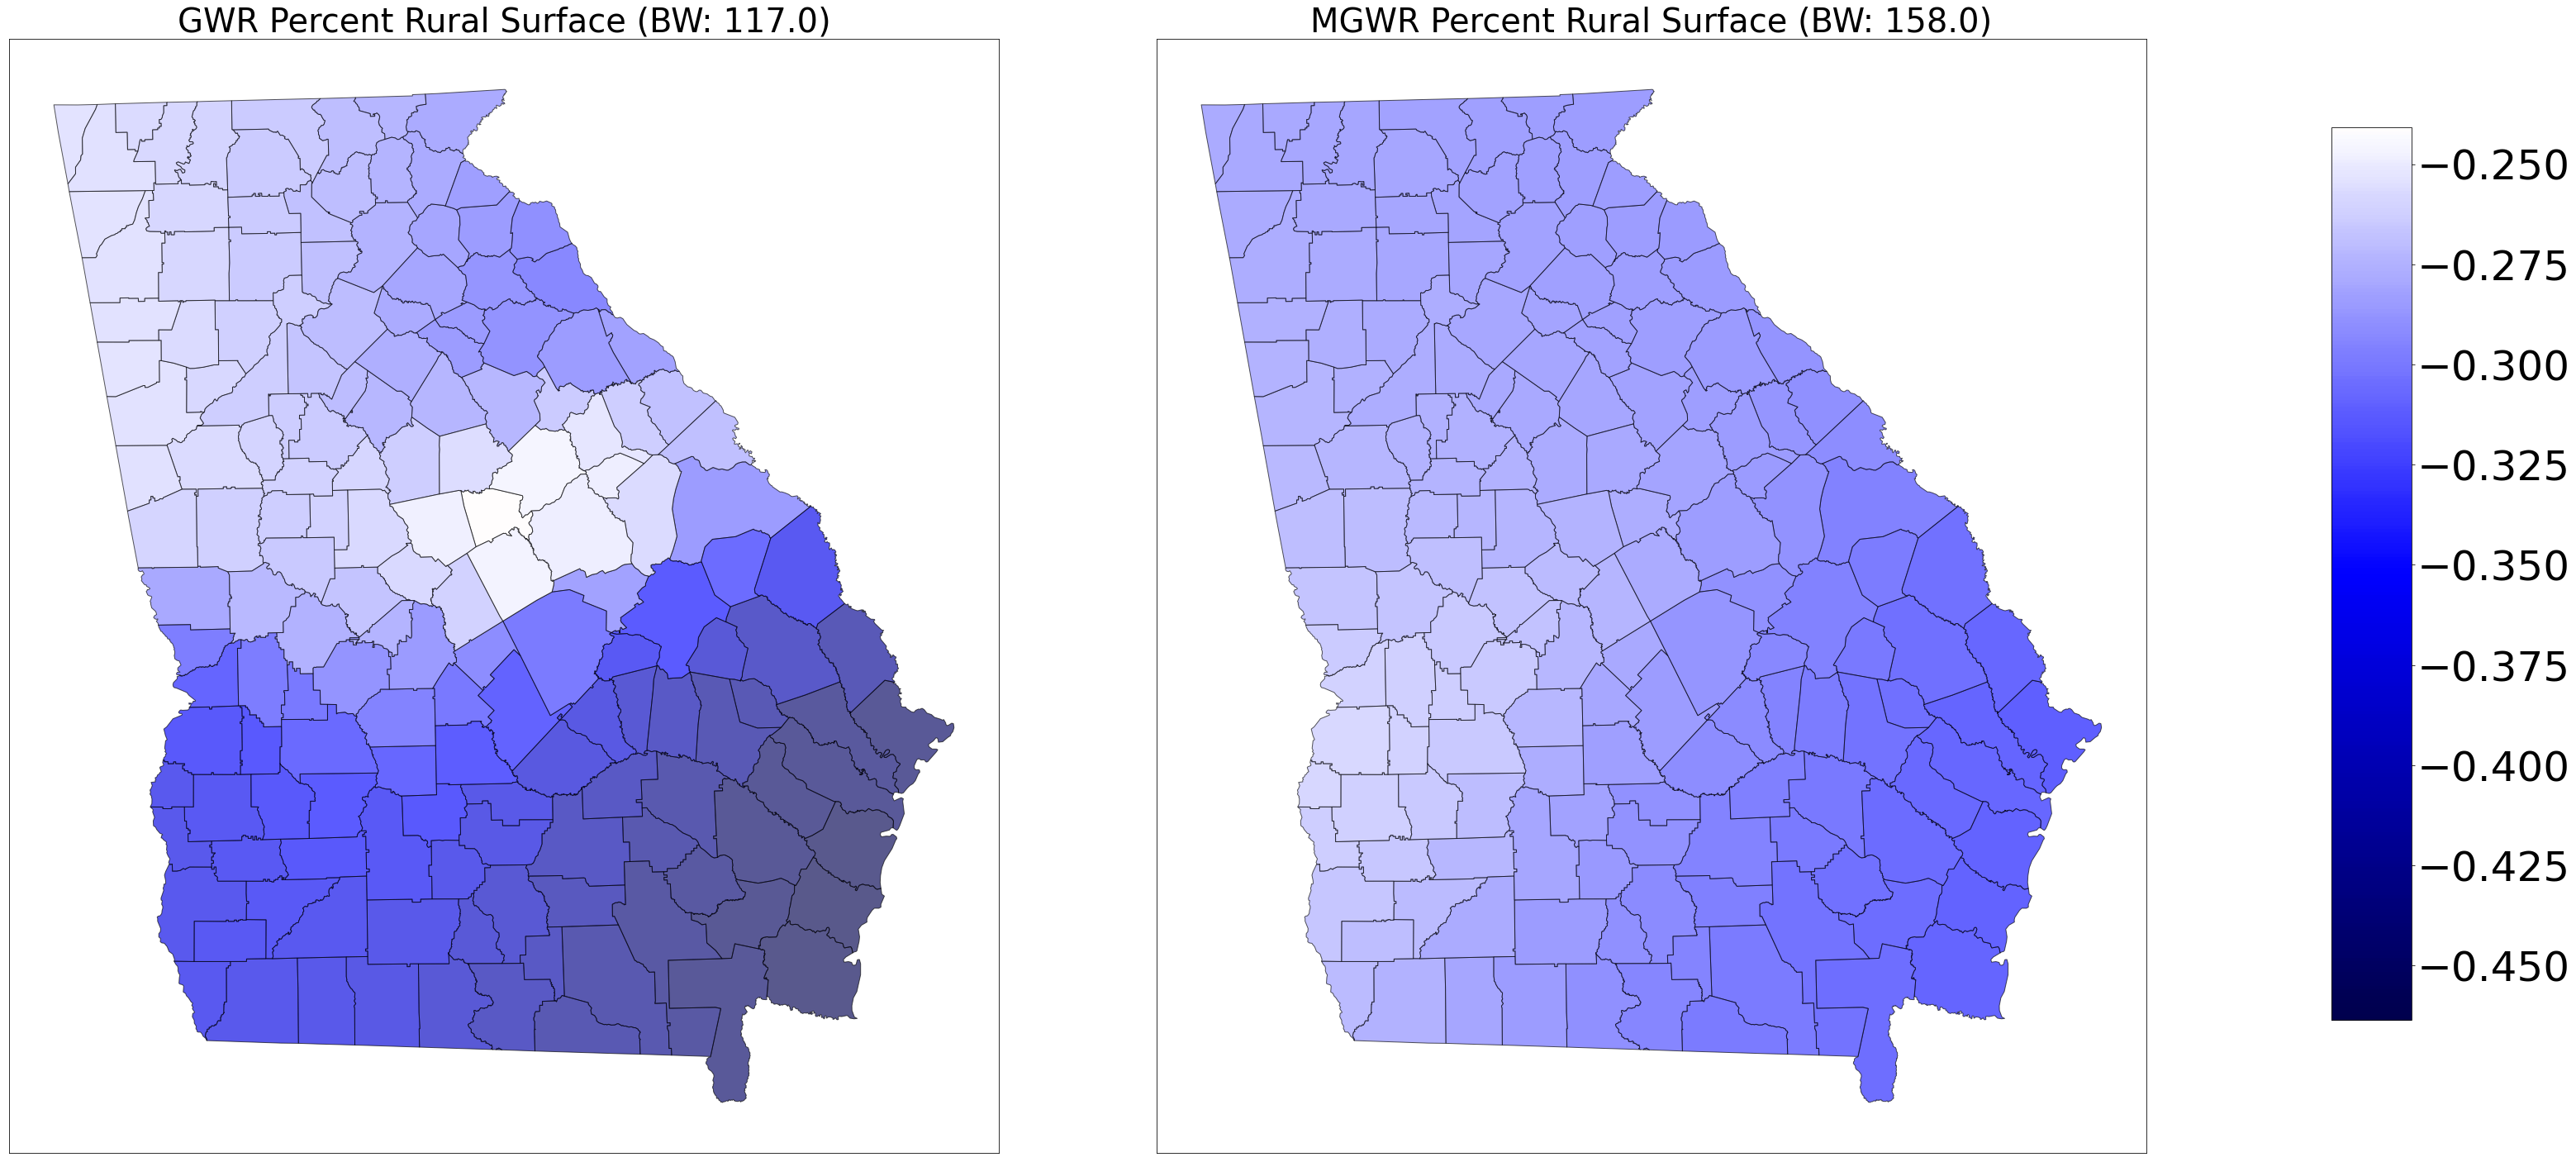

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(45,20))
ax0 = axes[0]
ax0.set_title('GWR Percent Rural Surface (BW: ' + str(gwr_bw) +')', fontsize=40)
ax1 = axes[1]
ax1.set_title('MGWR Percent Rural Surface (BW: ' + str(mgwr_bw[3]) +')', fontsize=40)
cmap = plt.cm.seismic
gwr_min = georgia_shp['gwr_rural'].min()
gwr_max = georgia_shp['gwr_rural'].max()
mgwr_min = georgia_shp['mgwr_rural'].min()
mgwr_max = georgia_shp['mgwr_rural'].max()
vmin = np.min([gwr_min, mgwr_min])
vmax = np.max([gwr_max, mgwr_max])

if (vmin < 0) & (vmax < 0):
    cmap = truncate_colormap(cmap, 0.0, 0.5)
elif (vmin > 0) & (vmax > 0):
    cmap = truncate_colormap(cmap, 0.5, 1.0)
else:
    cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

georgia_shp.plot('gwr_rural', cmap=sm.cmap, ax=ax0, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (gwr_filtered_t[:,3] == 0).any():
    georgia_shp[gwr_filtered_t[:,3] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

georgia_shp.plot('mgwr_rural', cmap=sm.cmap, ax=ax1, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
if (mgwr_filtered_t[:,3] == 0).any():
    georgia_shp[mgwr_filtered_t[:,3] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})

fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=50) 
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.show()